In [1]:
import pandas as pd
import numpy as np
from transpa.util import compute_autocorr
from transpa.eval_util import calc_corr
from scipy.spatial.distance import cosine 
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from scipy.stats.mstats import gmean
import scanpy as sc
import squidpy as sq
import pickle
import seaborn as sns

ST_names = ["mouseliver5fold", "melanoma5fold", "intestine5fold", "breastcancer5fold"]
methods = ["TransImp", "TransImpSpa", "TransImpCls", "TransImpClsSpa", "spaGE", "stPlus", "Tangram", "truth"]
sub_methods = ["TransImp", "TransImpSpa", "spaGE", "stPlus", "Tangram"]
color = ['#3274A1', '#E1812C', '#3A923A', '#C03D3E', '#9372B2', '#845B53', '#D684BD', '#c780e8']

In [2]:
pd.read_csv(f'../../output/{ST_names[0]}_{ST_names[0]}_{methods[0]}.csv', index_col=0, header=0)

0610010F05Rik  1110046J04Rik  1190005I06Rik  1200007C13Rik  \
0          0.675498       0.001219       1.014963       0.000819   
1          0.648066       0.000071       0.748466       0.001110   
2          0.567949       0.000185       0.651790       0.000760   
3          0.723390       0.001463       0.803153       0.000893   
4          0.699546       0.000403       0.842608       0.001720   
...             ...            ...            ...            ...   
2105       0.623078       0.000080       0.727191       0.000375   
2106       0.587748       0.000053       0.737591       0.000613   
2107       0.633897       0.001817       0.849935       0.001978   
2108       0.646742       0.000034       0.676263       0.000157   
2109       0.605264       0.000119       0.736184       0.000539   

      1500009L16Rik  1600020E01Rik  1700006J14Rik  1700017B05Rik  \
0          0.000050       0.214717       0.002414       0.299004   
1          0.000014       0.194658       0.029385       0.273061   
2          0.000024       0.161051       0.002691       0.266327   
3          0.000121       0.145056       0.002101       0.279912   
4          0.000075       0.212553       0.001707       0.305916   
...             ...            ...            ...            ...   
2105       0.000028       0.156031       0.003932       0.308394   
2106       0.000202       0.150347       0.001566       0.265330   
2107       0.000032       0.214677       0.005202       0.281285   
2108       0.000022       0.182836       0.000819       0.258986   
2109       0.000027       0.173768       0.004533       0.269425   

      1700020L24Rik  1700037C18Rik  ...    mt-Co1    mt-Co2    mt-Co3  \
0          0.091991       0.076216  ...  6.921685  6.830800  8.468703   
1          0.089034       0.069616  ...  5.860544  5.801924  7.308365   
2          0.032206       0.051553  ...  4.491259  4.456741  5.686265   
3          0.073437       0.057662  ...  6.792753  6.757545  7.915952   
4          0.114066       0.059254  ...  6.795084  6.766003  8.286669   
...             ...            ...  ...       ...       ...       ...   
2105       0.049235       0.071037  ...  5.317761  5.380729  7.038989   
2106       0.036761       0.059768  ...  4.911266  4.860375  6.177736   
2107       0.043502       0.054439  ...  5.611648  5.610648  7.342933   
2108       0.028571       0.045350  ...  4.256562  4.272663  6.244264   
2109       0.067273       0.070938  ...  5.597375  5.455802  7.028562   

       mt-Cytb    mt-Nd1    mt-Nd2    mt-Nd3    mt-Nd4   mt-Nd4l    mt-Nd5  
0     5.210904  5.799071  2.689609  1.447947  5.463171  1.461599  1.476337  
1     4.574588  4.902112  2.324548  1.198159  4.620713  1.209799  1.368256  
2     3.452572  3.821849  1.696140  0.914820  3.845358  1.044374  1.032326  
3     5.183559  5.453779  2.560299  1.201176  5.382814  1.637295  1.527433  
4     5.378968  5.551468  2.492868  1.350647  5.523571  1.503042  1.595100  
...        ...       ...       ...       ...       ...       ...       ...  
2105  4.348171  4.781815  2.220702  1.112284  4.772967  1.202970  1.217966  
2106  3.622417  4.174634  1.851351  0.945855  4.021467  1.099539  1.094296  
2107  4.390528  5.008295  2.135395  1.110993  4.339862  1.129153  1.254382  
2108  3.323333  4.182070  1.760295  0.882800  3.996391  1.051988  0.940055  
2109  4.234057  4.641671  1.994236  1.092190  4.476117  1.177156  1.255570  

[2110 rows x 4517 columns]

In [3]:
def cmp_scores(ST_name, thred_cos=0.2, thred_mseI=0.1, thred_fdr=0.01):
    dict_df = {method: pd.read_csv(f'../../output/{ST_name}_{ST_name}_{method}.csv', index_col=0, header=0) for method in methods}

    with open(f"../../output/{ST_name}ext_small_train_eval_results.pkl", 'rb') as infile:
        eval_res, spa_adata, dict_adata = pickle.load(infile)

    with open(f"../../output/{ST_name}_spatialdm.pkl", 'rb') as infile:
        m_adatas = pickle.load(infile)

    df_se_moranI = pd.DataFrame(dict(sorted(eval_res['se_moranI'].items())))
    df_corr      = pd.DataFrame(dict(sorted(eval_res['pred_corr'].items())))
    df_fdr     = pd.DataFrame(dict(sorted(eval_res['fdr'].items())))
    df_pval     = pd.DataFrame(dict(sorted(eval_res['pval'].items())))
    df_I     = pd.DataFrame(dict(sorted(eval_res['I'].items())))
    df_fdr['truth'] = spa_adata.uns['moranI'].loc[df_fdr.index.values,:].pval_norm_fdr_bh
    df_I['truth'] = spa_adata.uns['moranI'].loc[df_fdr.index.values,:].I
    df_pval['truth'] = spa_adata.uns['moranI'].loc[df_pval.index.values,:].pval_norm

    dict_sparkx_cmbpvals = {}
    dict_sparkx_adjpvals = {}
    ca_genes = None

    for md in methods:
        df = pd.read_csv(f"../../output/sparkx_{ST_name}_{md}.csv", header=0, index_col=0)
        if ca_genes is None:
            ca_genes = df.index.values
        
        shared_gene = np.intersect1d(ca_genes, df.index.values)
        if len(shared_gene) < len(ca_genes):
            miss_gene  = np.setdiff1d(ca_genes, shared_gene)
            df = pd.concat([df, pd.DataFrame({"combinedPval":{g:1.0 for g in miss_gene},"adjustedPval":{g:1.0 for g in miss_gene} })], axis=0)
        dict_sparkx_cmbpvals[md] = df.loc[ca_genes, 'combinedPval']
        dict_sparkx_adjpvals[md] = df.loc[ca_genes, 'adjustedPval']
    df_sparkx_cmbpvals = pd.DataFrame(dict_sparkx_cmbpvals)
    df_sparkx_adjpvals = pd.DataFrame(dict_sparkx_adjpvals)  

    method_moranI_ratio = {f"{ST_name}_mse_moranI_st{thred_mseI}_ratio":{}}
    method_moranI = {f"{ST_name}_mse_moranI":{}}
    method_cos = {f"{ST_name}_cos_corr":{}}
    method_cos_ratio = {f"{ST_name}_cos_gt{thred_cos}_ratio":{}}
    method_meanprecision_moranI = {f"{ST_name}_mean_prec_moranI":{}}
    method_meanprecision_sparkx = {f"{ST_name}_mean_prec_sparkx":{}}
    method_meanprecision_spatialdm = {f"{ST_name}_mean_prec_spatialdm":{}}
    
    
    idx = -1
    plt.rcParams.update({"font.size":18, 'axes.titlesize':20})
    plt.rcParams["figure.dpi"] = 380
    _, ax = plt.subplots(figsize=(8, 7))
    for method in dict_df:
        
        corrs = []
        for gene in dict_df['truth'].columns:
            u, v = dict_df['truth'][gene].values, dict_df[method][gene].values
            if (v != 0).sum() == 0:
                corrs.append(np.nan)
            else:
                corrs.append(1 - cosine(u, v))
        corrs = np.array(corrs)
        np.nan_to_num(corrs, copy=False, nan=np.nanmin(corrs))
        
        eval_res['pred_corr'][method] = corrs

        print(np.median(corrs), np.median(corrs[corrs > thred_cos] ))
        
        mse_moranI = (dict_adata[method].uns['moranI'].I.values - dict_adata["truth"].uns['moranI'].I.values)**2
        
        sel = (~np.isnan(df_I['truth'].values) ) # & (~np.isnan(df_I[method].values))
        sel = sel & (df_I.truth.values >= 0)
        truth_pval, preds_pval = df_fdr.truth.values[sel], df_fdr[method][sel]
        
        np.nan_to_num(df_I[method].values, copy=False, nan=-1)
        score = df_I[method][sel]
        print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}, Ground Sig/Total ({(truth_pval < thred_fdr).sum()}/{truth_pval.shape[0]}), Pred Sig/total ({(preds_pval < thred_fdr).sum()}/{preds_pval.shape[0]})')
        
        np.nan_to_num(mse_moranI, copy=False, nan=(np.nanmax(mse_moranI)))
        eval_res['se_moranI'][method] = mse_moranI


        method_moranI[f"{ST_name}_mse_moranI"][method] = np.median(mse_moranI)
        method_cos[f"{ST_name}_cos_corr"][method] = np.median(corrs)

        method_cos_ratio[f"{ST_name}_cos_gt{thred_cos}_ratio"][method] = (corrs > thred_cos).sum()/len(corrs)
        method_moranI_ratio[f"{ST_name}_mse_moranI_st{thred_mseI}_ratio"][method] = (mse_moranI < thred_mseI).sum() / len(mse_moranI)
        method_meanprecision_moranI[f"{ST_name}_mean_prec_moranI"][method] = metrics.average_precision_score(truth_pval < thred_fdr, score)

        if method in {'TransImpCls', 'TransImpClsSpa', 'truth'}: continue
        idx += 1
        prec, rec, thresholds  = metrics.precision_recall_curve(truth_pval < thred_fdr, score, pos_label=1)
        disp = metrics.PrecisionRecallDisplay(precision=prec, recall=rec)
        disp.plot(ax=ax, name = f"{method} (AUC=({metrics.average_precision_score(truth_pval < thred_fdr, score):.2f})", color=color[idx])
        
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])

    ax.set_title(f'Precison-Recall Curve on Moran\'s I HVG Test ({ST_name.replace("5fold", "").capitalize()})')
    ax.legend(loc="best")
    plt.show()

    idx = -1
    plt.rcParams["figure.dpi"] = 380
    plt.rcParams.update({"font.size":18, 'axes.titlesize':20})
    _, ax = plt.subplots(figsize=(8, 7))
    for method in dict_df:
        # Sparkx

        sel = (~np.isnan(df_sparkx_adjpvals['truth'].values) ) & (~np.isnan(df_sparkx_adjpvals[method].values))
        print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}')
        truth_pval, method_pval = df_sparkx_adjpvals.truth.values[sel], df_sparkx_adjpvals[method][sel]
        score = -np.log(df_sparkx_adjpvals[method][sel].values + min(np.min(df_sparkx_adjpvals[method][sel].values) * 1e-3, 1e-500))
        method_meanprecision_sparkx[f"{ST_name}_mean_prec_sparkx"][method] = metrics.average_precision_score(truth_pval < thred_fdr, score)
        if method in {'TransImpCls', 'TransImpClsSpa', 'truth'}: continue
        idx += 1       
    
        prec, rec, thresholds  = metrics.precision_recall_curve(truth_pval < thred_fdr, score, pos_label=1)        
        disp = metrics.PrecisionRecallDisplay(precision=prec, recall=rec)   
        disp.plot(ax=ax, name = f"{method} (AUC=({metrics.average_precision_score(truth_pval < thred_fdr, score):.2f})", color=color[idx])
    
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])

    ax.set_title(f'Precison-Recall Curve on SparkX HVG Test ({ST_name.replace("5fold", "").capitalize()})')
    ax.legend(loc="best")
    plt.show()

    plt.rcParams["figure.dpi"] = 380
    plt.rcParams.update({"font.size":18, 'axes.titlesize':20})
    _, ax = plt.subplots(figsize=(8, 7))
    idx = -1
    for method in dict_df:
        # SpatialDM
        truth_res = m_adatas['truth'].uns['global_res'].loc[m_adatas['truth'].uns['global_I'] >= 0].copy()
        genes = np.intersect1d(truth_res.index, m_adatas[method].uns['global_res'].index)
        print(f"{method} # {len(genes)} pairs, # sig pairs: (Truth): {truth_res.loc[genes].selected.values.sum()}, (Preds) {m_adatas[method].uns['global_res'].loc[genes].selected.values.sum()}")
        if len(genes) < len(truth_res.index):
            print(f"{method} Fewer genes than truth: {len(genes)} vs {len(truth_res.index)}")
        y = truth_res.loc[genes].selected.values
       
        score =  - np.log(m_adatas[method].uns['global_res'].loc[genes].fdr.values + min(np.min(m_adatas[method].uns['global_res'].loc[genes].fdr.values)/1000, 1e-500))
        score[np.isinf(score)] = score[~np.isinf(score)].max()*10
        method_meanprecision_spatialdm[f"{ST_name}_mean_prec_spatialdm"][method] = metrics.average_precision_score(y, score)

        if method in {'TransImpCls', 'TransImpClsSpa', 'truth'}: continue
        idx += 1 

        prec, rec, thresholds  = metrics.precision_recall_curve(y, score, pos_label=1)
        
        disp = metrics.PrecisionRecallDisplay(precision=prec, recall=rec)   
        disp.plot(ax=ax, name = f"{method} (AUC=({metrics.average_precision_score(y, score):.2f})", color=color[idx])
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])

    ax.set_title(f'Precison-Recall Curve on Sig. Ligand-Receptor ({ST_name.replace("5fold", "").capitalize()})')
    ax.legend(loc="best")
    plt.show()     
    return method_cos_ratio, method_moranI_ratio, method_meanprecision_moranI, method_meanprecision_sparkx, method_meanprecision_spatialdm, method_moranI, method_cos

# cmp_scores(ST_names[2], 0.2, 0.05, 0.01)

0.5056531917123063 0.5560000162882542
(TransImp) Valid genes: 3546/4517, Ground Sig/Total (808/3546), Pred Sig/total (3343/3546)
0.5028532328773107 0.5539842510199784
(TransImpSpa) Valid genes: 3546/4517, Ground Sig/Total (808/3546), Pred Sig/total (1837/3546)
0.5165320277175559 0.5565459210416417
(TransImpCls) Valid genes: 3546/4517, Ground Sig/Total (808/3546), Pred Sig/total (3523/3546)
0.5139833297304193 0.5547495266516855
(TransImpClsSpa) Valid genes: 3546/4517, Ground Sig/Total (808/3546), Pred Sig/total (2398/3546)
0.41112371451629903 0.4739018200216413
(spaGE) Valid genes: 3546/4517, Ground Sig/Total (808/3546), Pred Sig/total (3351/3546)
0.42002087797141285 0.526789097681462
(stPlus) Valid genes: 3546/4517, Ground Sig/Total (808/3546), Pred Sig/total (0/3546)
0.5134445642536275 0.5531384770301901
(Tangram) Valid genes: 3546/4517, Ground Sig/Total (808/3546), Pred Sig/total (3517/3546)
1.0 1.0
(truth) Valid genes: 3546/4517, Ground Sig/Total (808/3546), Pred Sig/total (808/3546

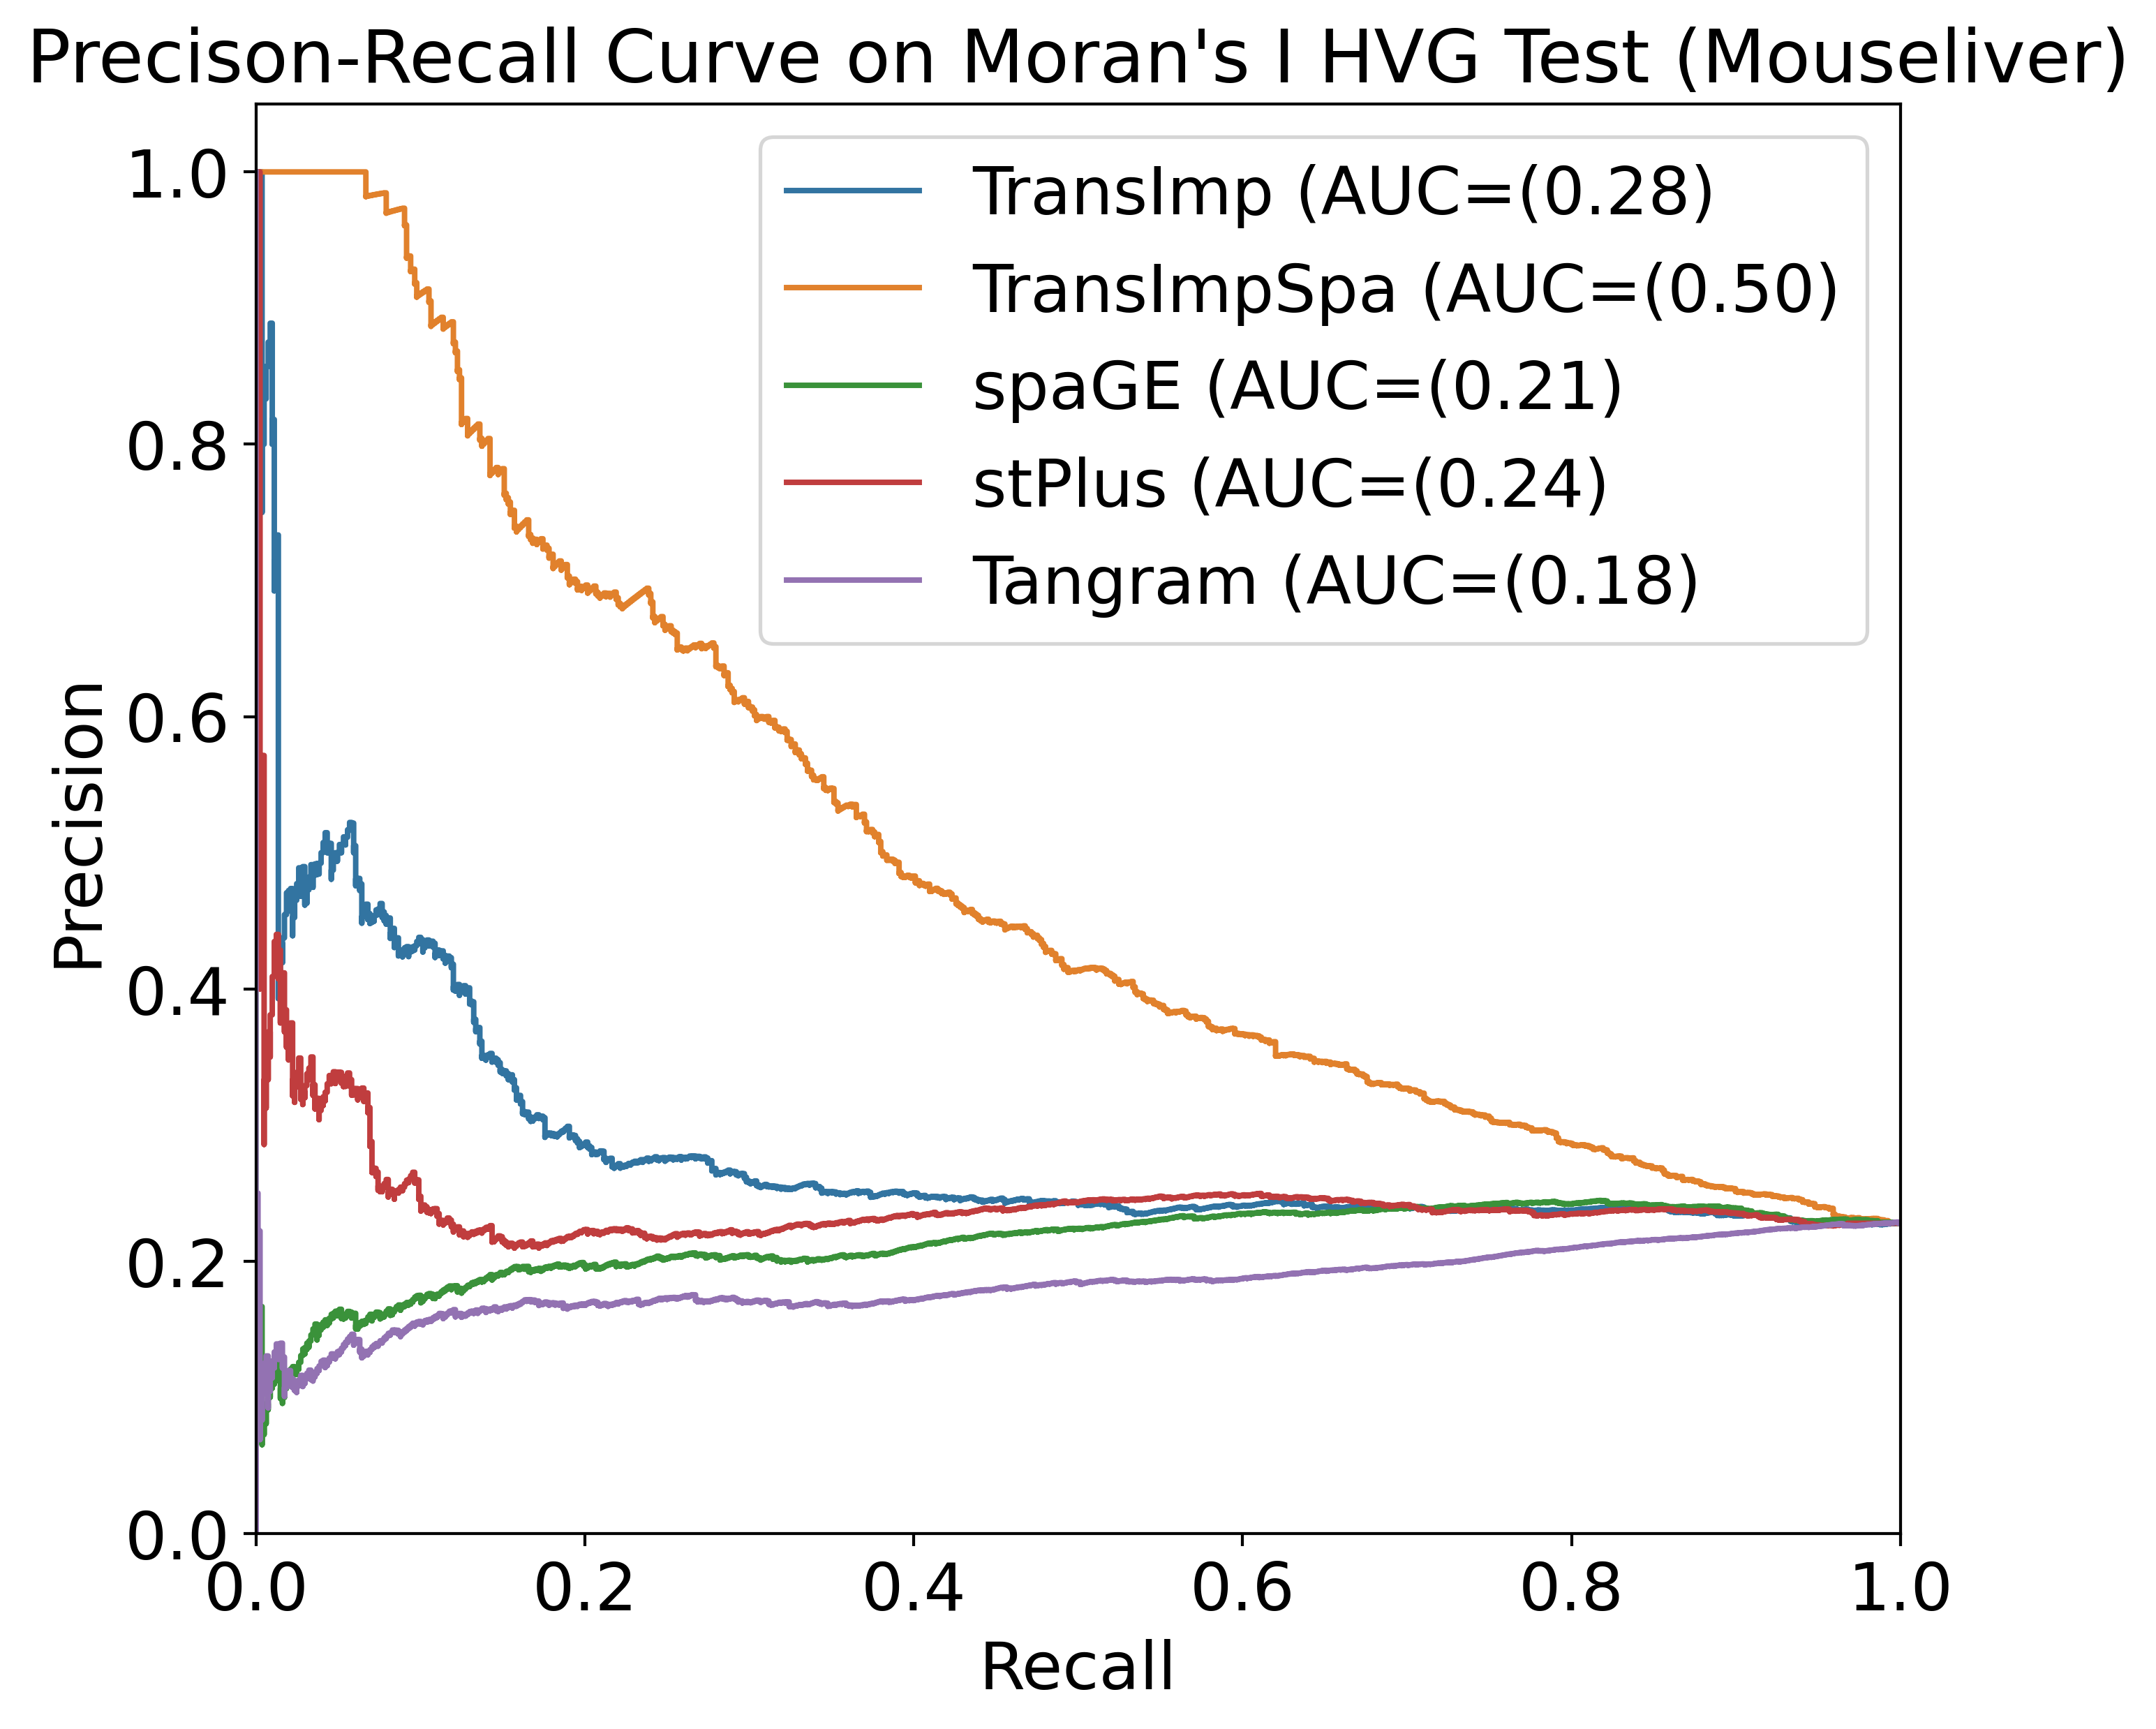

(TransImp) Valid genes: 4517/4517
(TransImpSpa) Valid genes: 4517/4517
(TransImpCls) Valid genes: 4517/4517
(TransImpClsSpa) Valid genes: 4517/4517
(spaGE) Valid genes: 4517/4517
(stPlus) Valid genes: 4517/4517
(Tangram) Valid genes: 4517/4517
(truth) Valid genes: 4517/4517


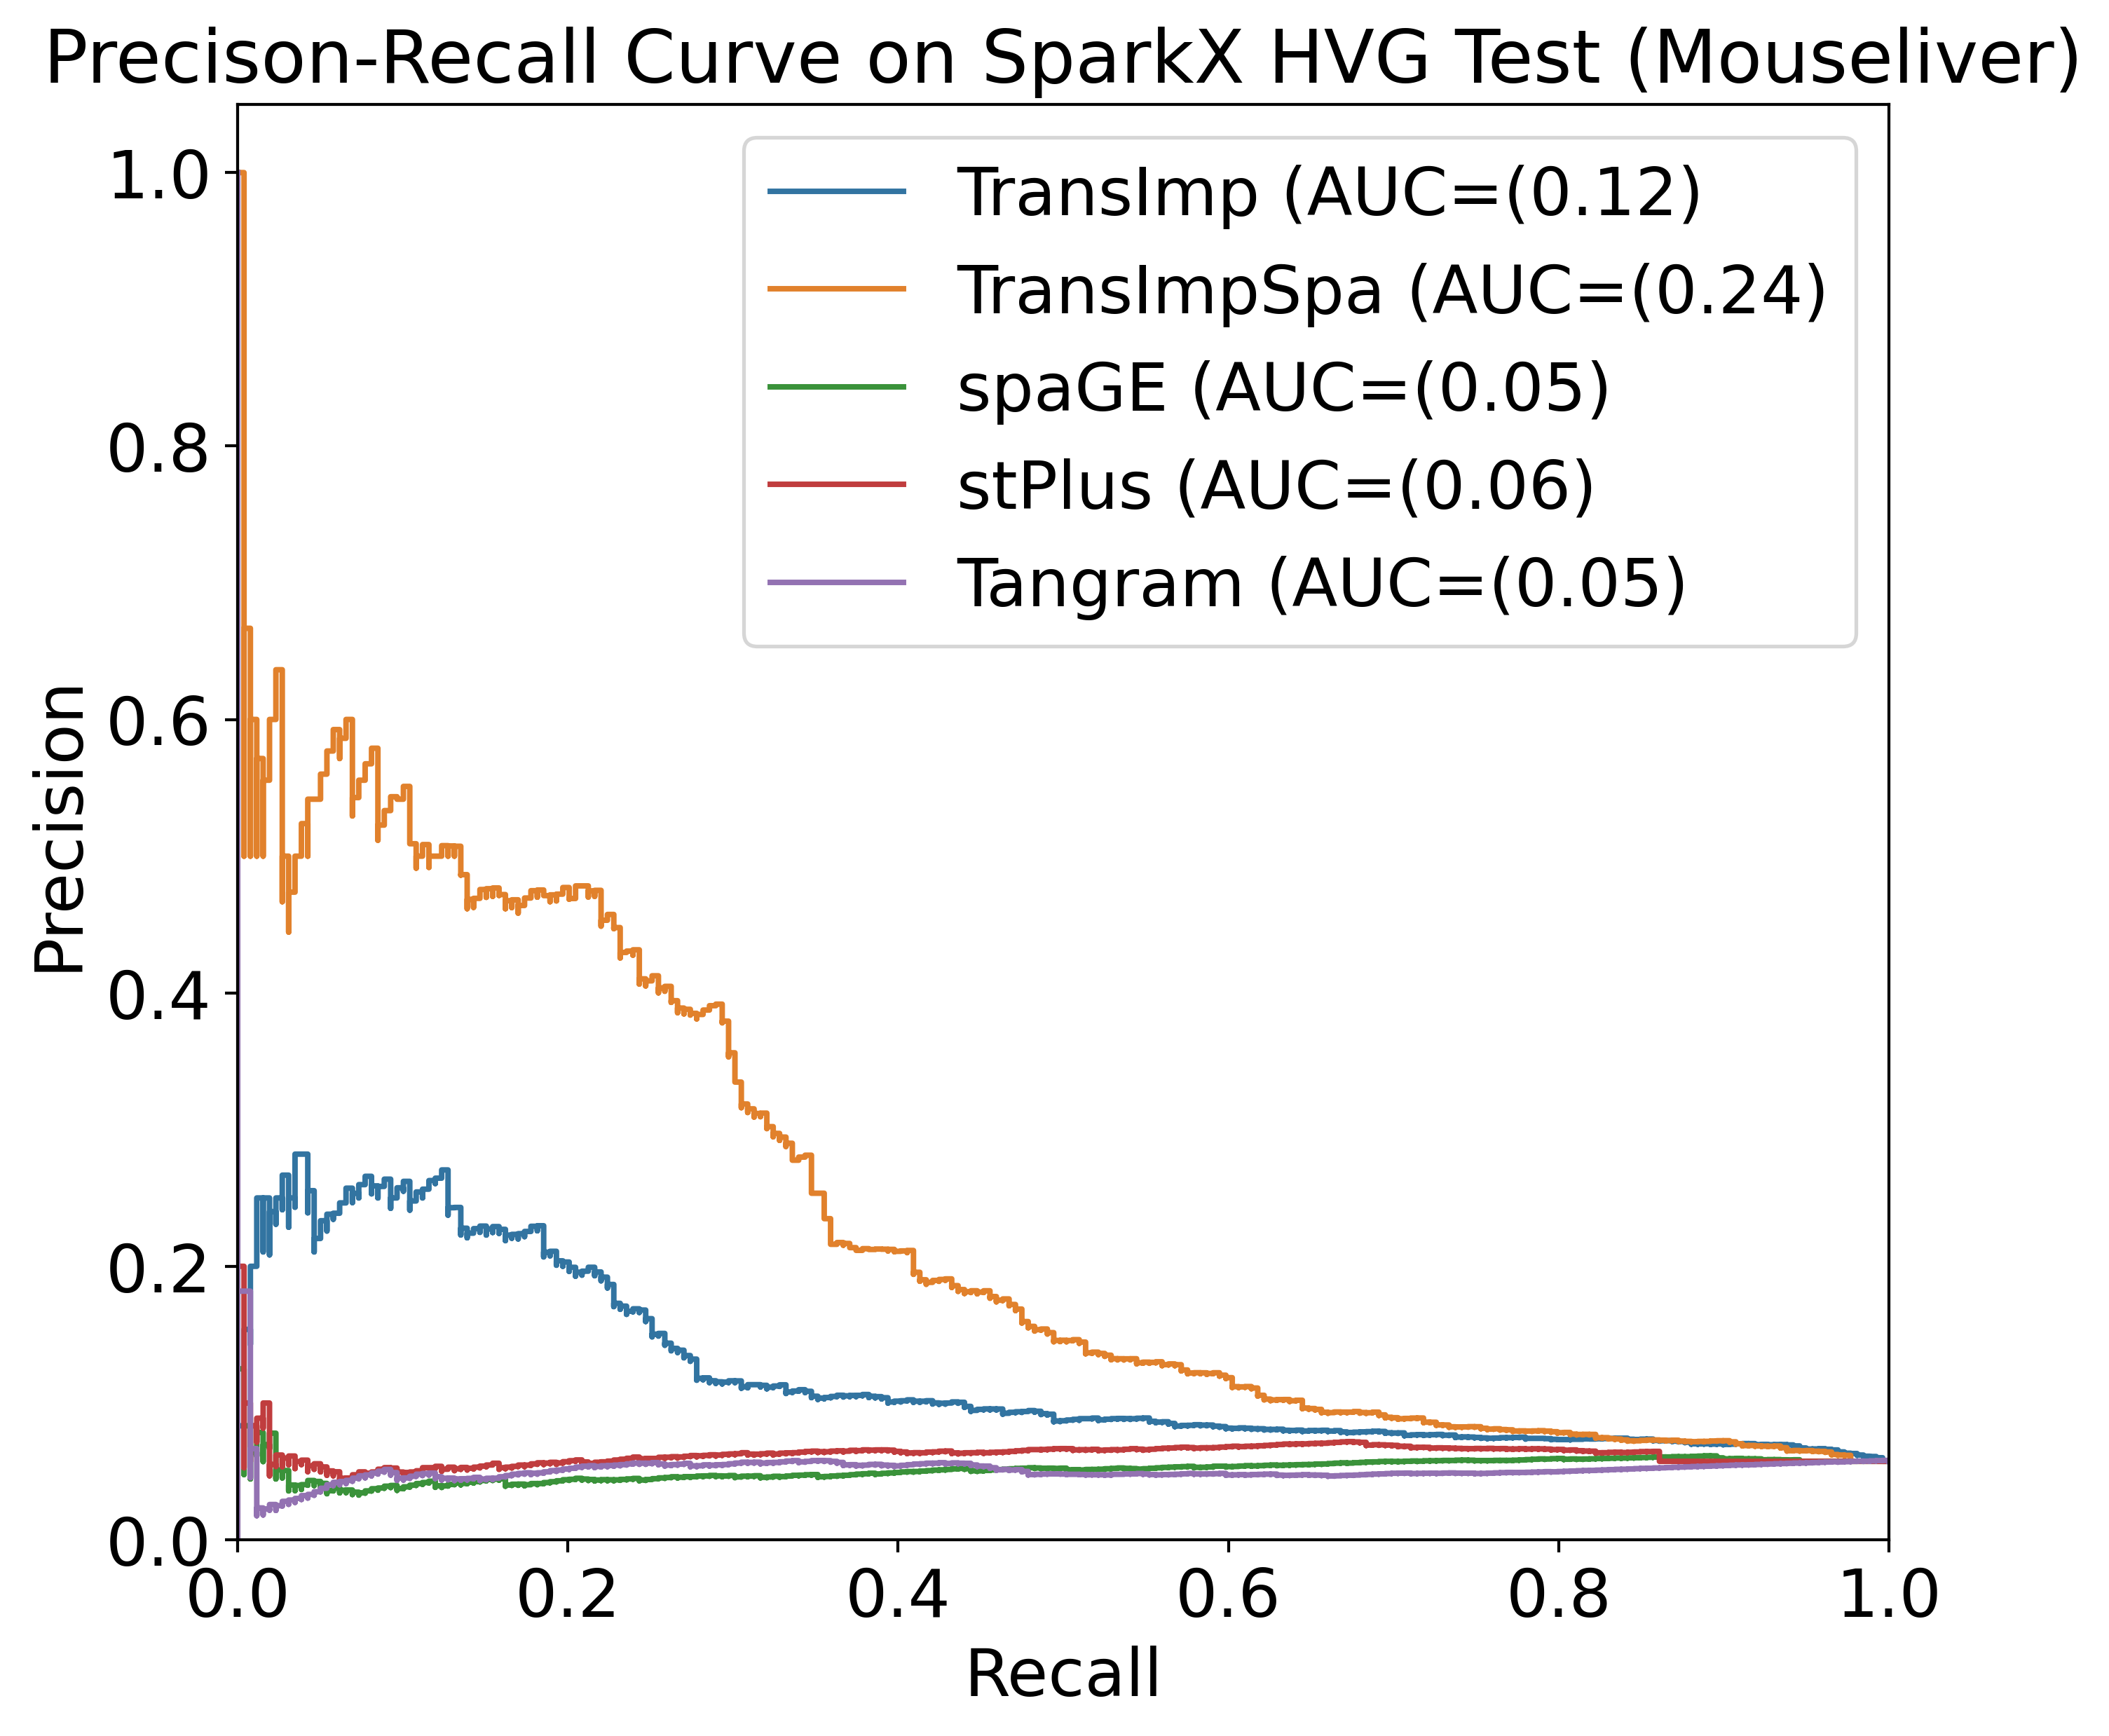

TransImp # 262 pairs, # sig pairs: (Truth): 24, (Preds) 109
TransImpSpa # 262 pairs, # sig pairs: (Truth): 24, (Preds) 102
TransImpCls # 262 pairs, # sig pairs: (Truth): 24, (Preds) 112
TransImpClsSpa # 262 pairs, # sig pairs: (Truth): 24, (Preds) 104
spaGE # 262 pairs, # sig pairs: (Truth): 24, (Preds) 87
stPlus # 262 pairs, # sig pairs: (Truth): 24, (Preds) 78
Tangram # 262 pairs, # sig pairs: (Truth): 24, (Preds) 112
truth # 262 pairs, # sig pairs: (Truth): 24, (Preds) 24


/tmp/ipykernel_4124788/3741029158.py:139: RuntimeWarning: divide by zero encountered in log
  score =  - np.log(m_adatas[method].uns['global_res'].loc[genes].fdr.values + min(np.min(m_adatas[method].uns['global_res'].loc[genes].fdr.values)/1000, 1e-500))
/tmp/ipykernel_4124788/3741029158.py:139: RuntimeWarning: divide by zero encountered in log
  score =  - np.log(m_adatas[method].uns['global_res'].loc[genes].fdr.values + min(np.min(m_adatas[method].uns['global_res'].loc[genes].fdr.values)/1000, 1e-500))
/tmp/ipykernel_4124788/3741029158.py:139: RuntimeWarning: divide by zero encountered in log
  score =  - np.log(m_adatas[method].uns['global_res'].loc[genes].fdr.values + min(np.min(m_adatas[method].uns['global_res'].loc[genes].fdr.values)/1000, 1e-500))
/tmp/ipykernel_4124788/3741029158.py:139: RuntimeWarning: divide by zero encountered in log
  score =  - np.log(m_adatas[method].uns['global_res'].loc[genes].fdr.values + min(np.min(m_adatas[method].uns['global_res'].loc[genes].fdr.val

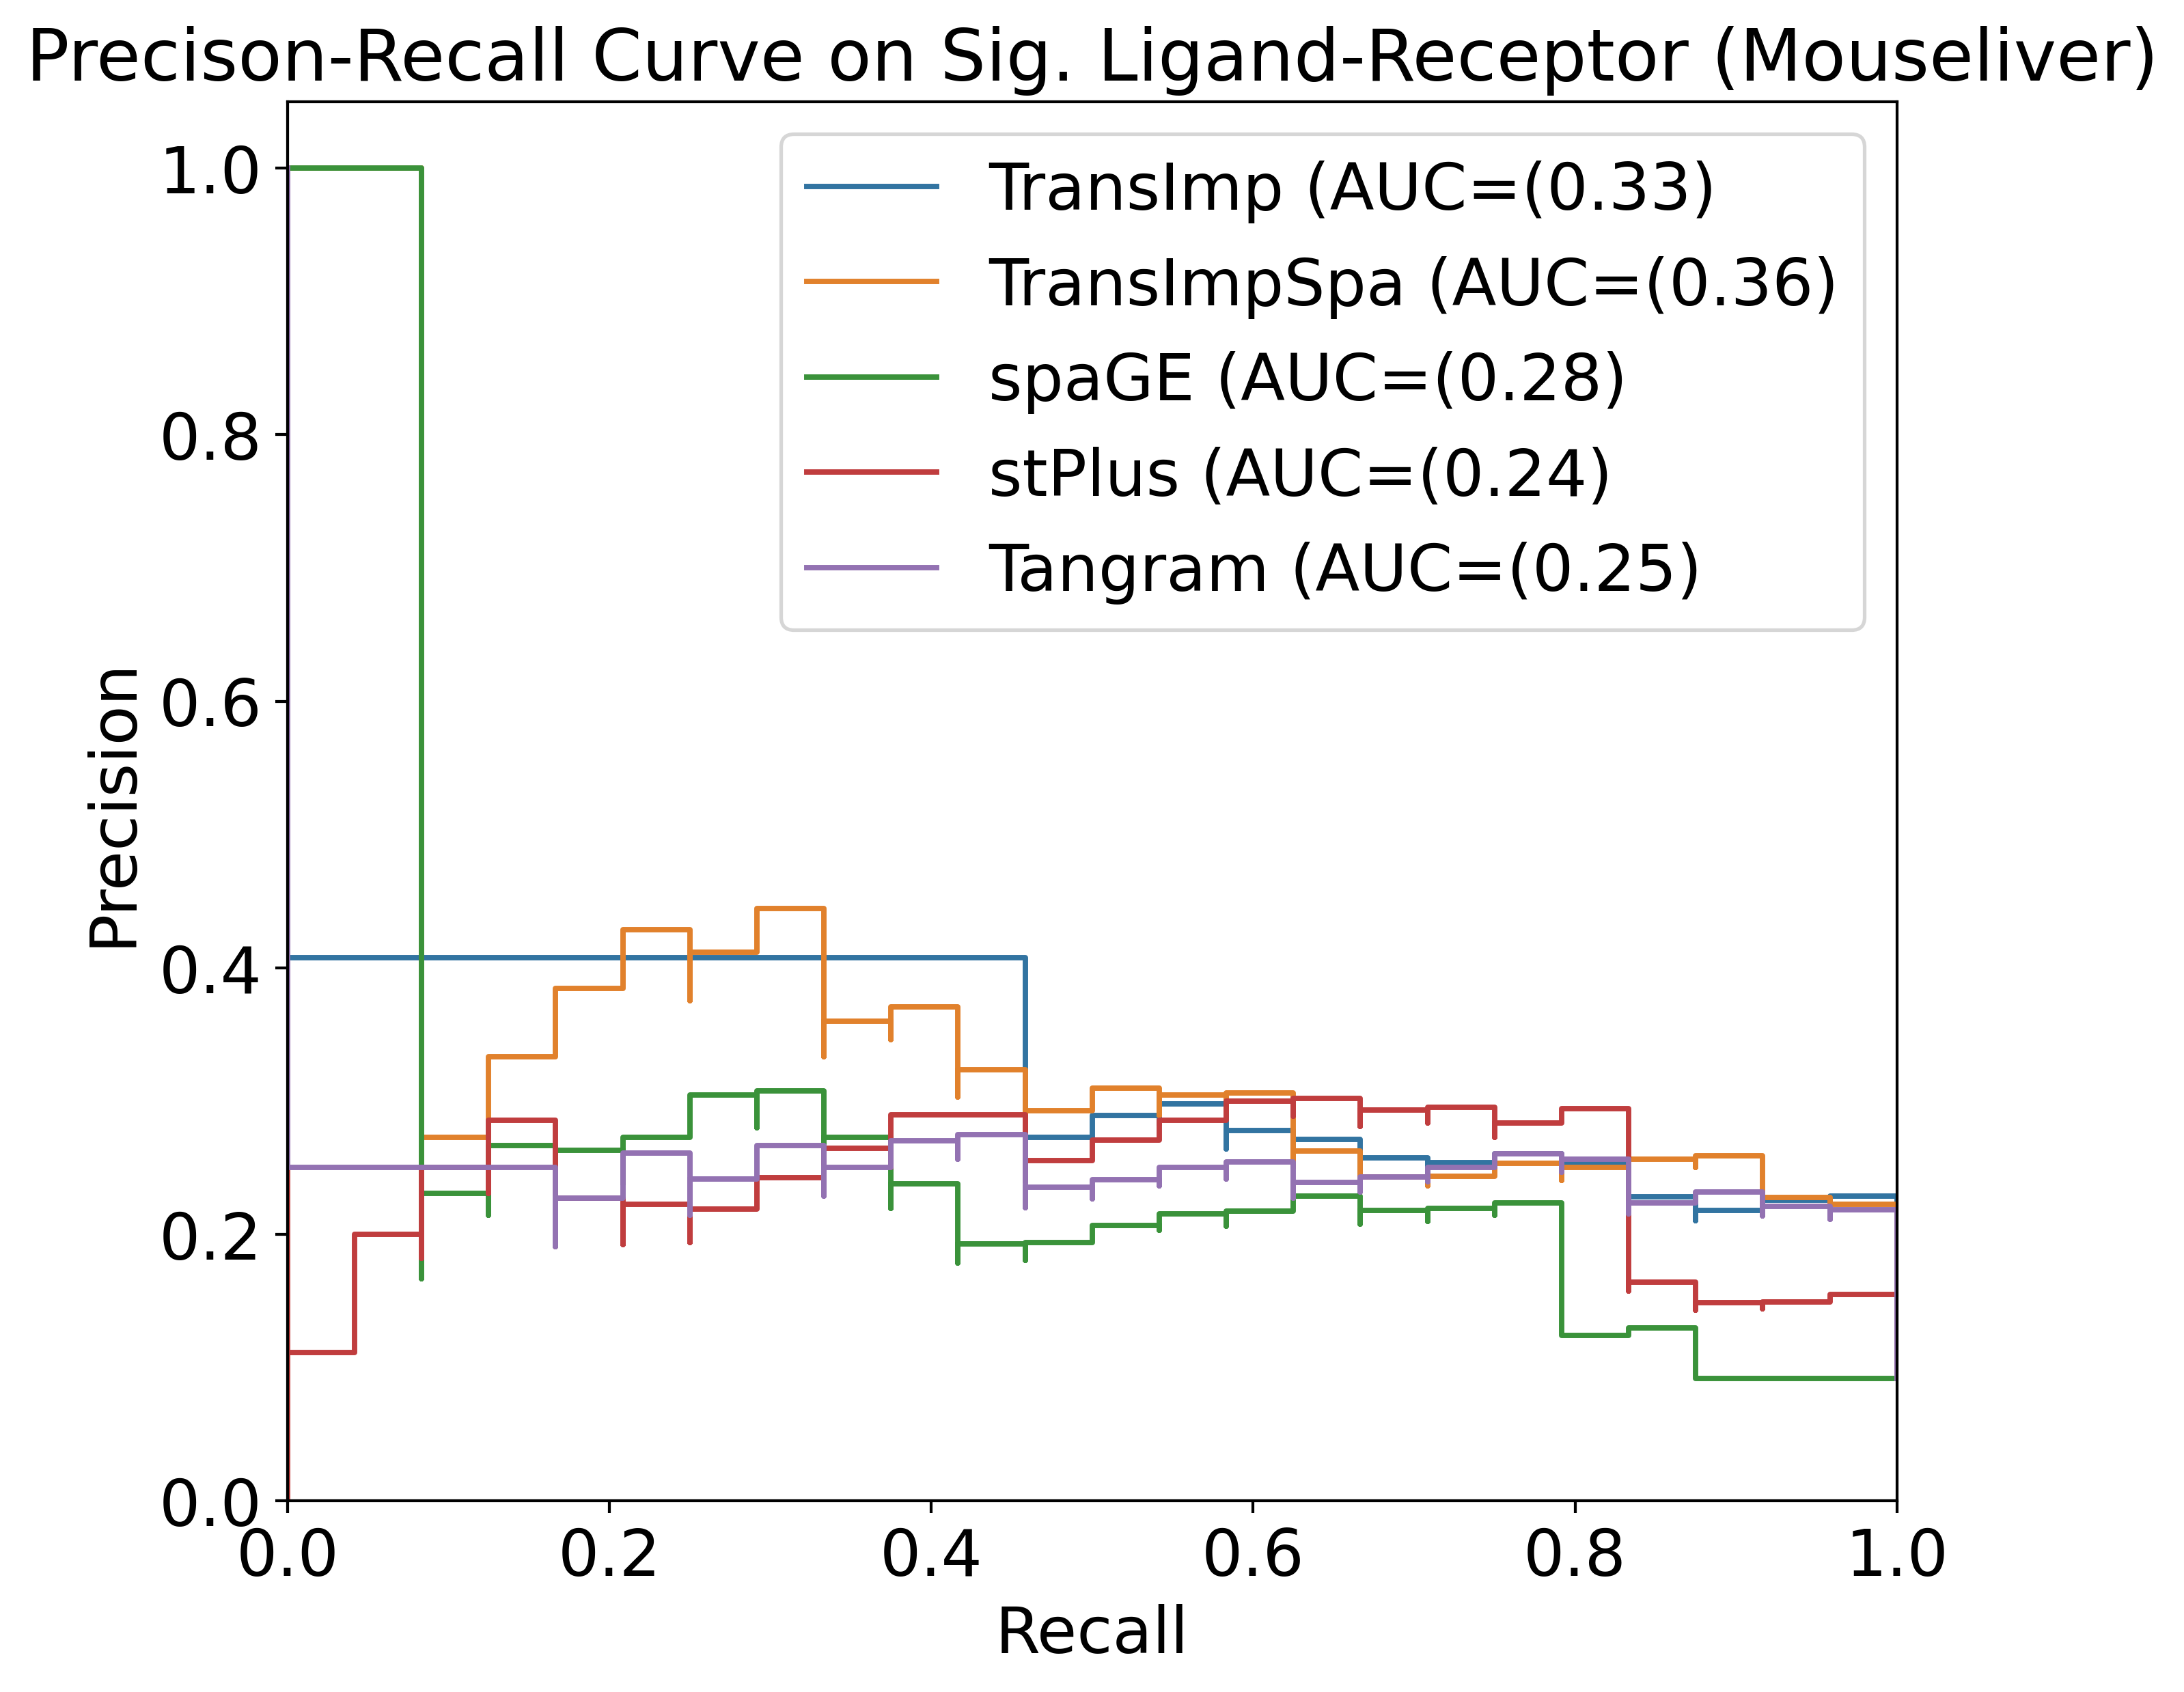

0.2889110861899328 0.34910564844953684
(TransImp) Valid genes: 2681/5380, Ground Sig/Total (759/2681), Pred Sig/total (2649/2681)
0.2804834101422747 0.34164405004163845
(TransImpSpa) Valid genes: 2681/5380, Ground Sig/Total (759/2681), Pred Sig/total (339/2681)
0.29389801282152267 0.35525964168860535
(TransImpCls) Valid genes: 2681/5380, Ground Sig/Total (759/2681), Pred Sig/total (2665/2681)
0.2899775283925403 0.35146312440458904
(TransImpClsSpa) Valid genes: 2681/5380, Ground Sig/Total (759/2681), Pred Sig/total (0/2681)
0.26482386031649885 0.34854492602341436
(spaGE) Valid genes: 2681/5380, Ground Sig/Total (759/2681), Pred Sig/total (2449/2681)
0.26241601758160715 0.3476984974087641
(stPlus) Valid genes: 2681/5380, Ground Sig/Total (759/2681), Pred Sig/total (0/2681)
0.29086393495473967 0.35213709546293437
(Tangram) Valid genes: 2681/5380, Ground Sig/Total (759/2681), Pred Sig/total (2654/2681)
1.0 1.0
(truth) Valid genes: 2681/5380, Ground Sig/Total (759/2681), Pred Sig/total (759

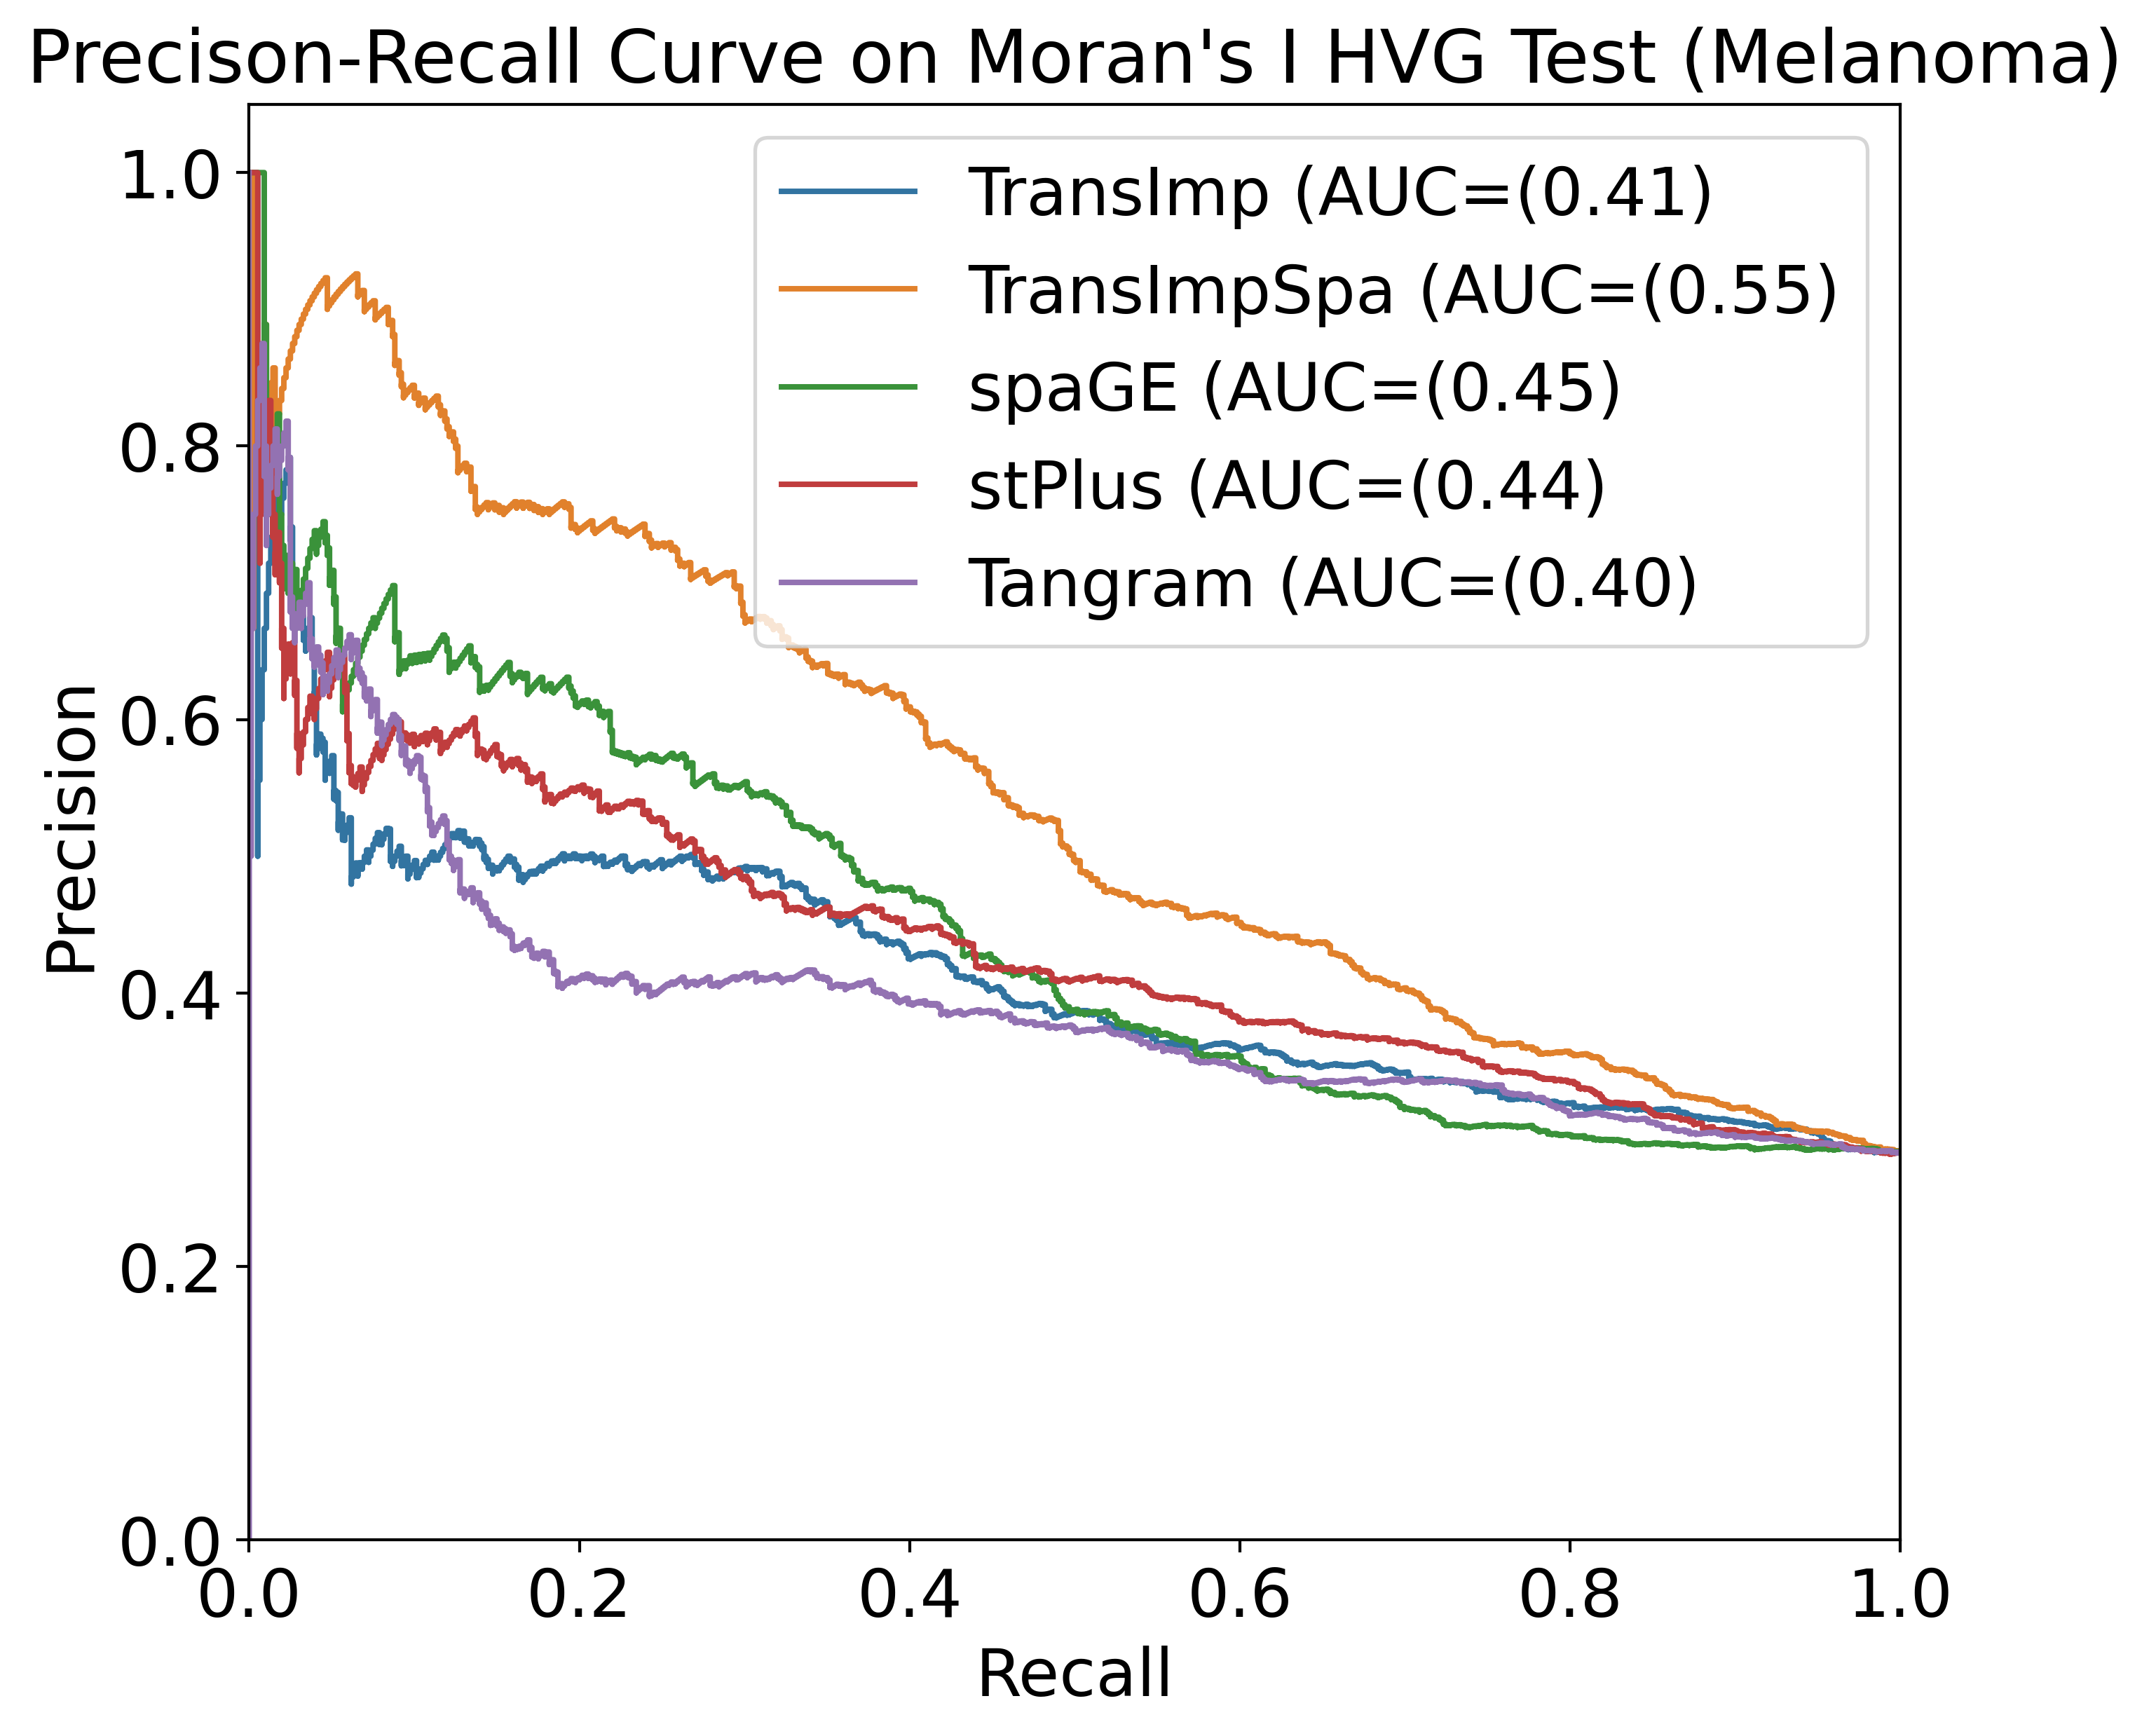

(TransImp) Valid genes: 5380/5380
(TransImpSpa) Valid genes: 5380/5380
(TransImpCls) Valid genes: 5380/5380
(TransImpClsSpa) Valid genes: 5380/5380
(spaGE) Valid genes: 5380/5380
(stPlus) Valid genes: 5380/5380
(Tangram) Valid genes: 5380/5380
(truth) Valid genes: 5380/5380


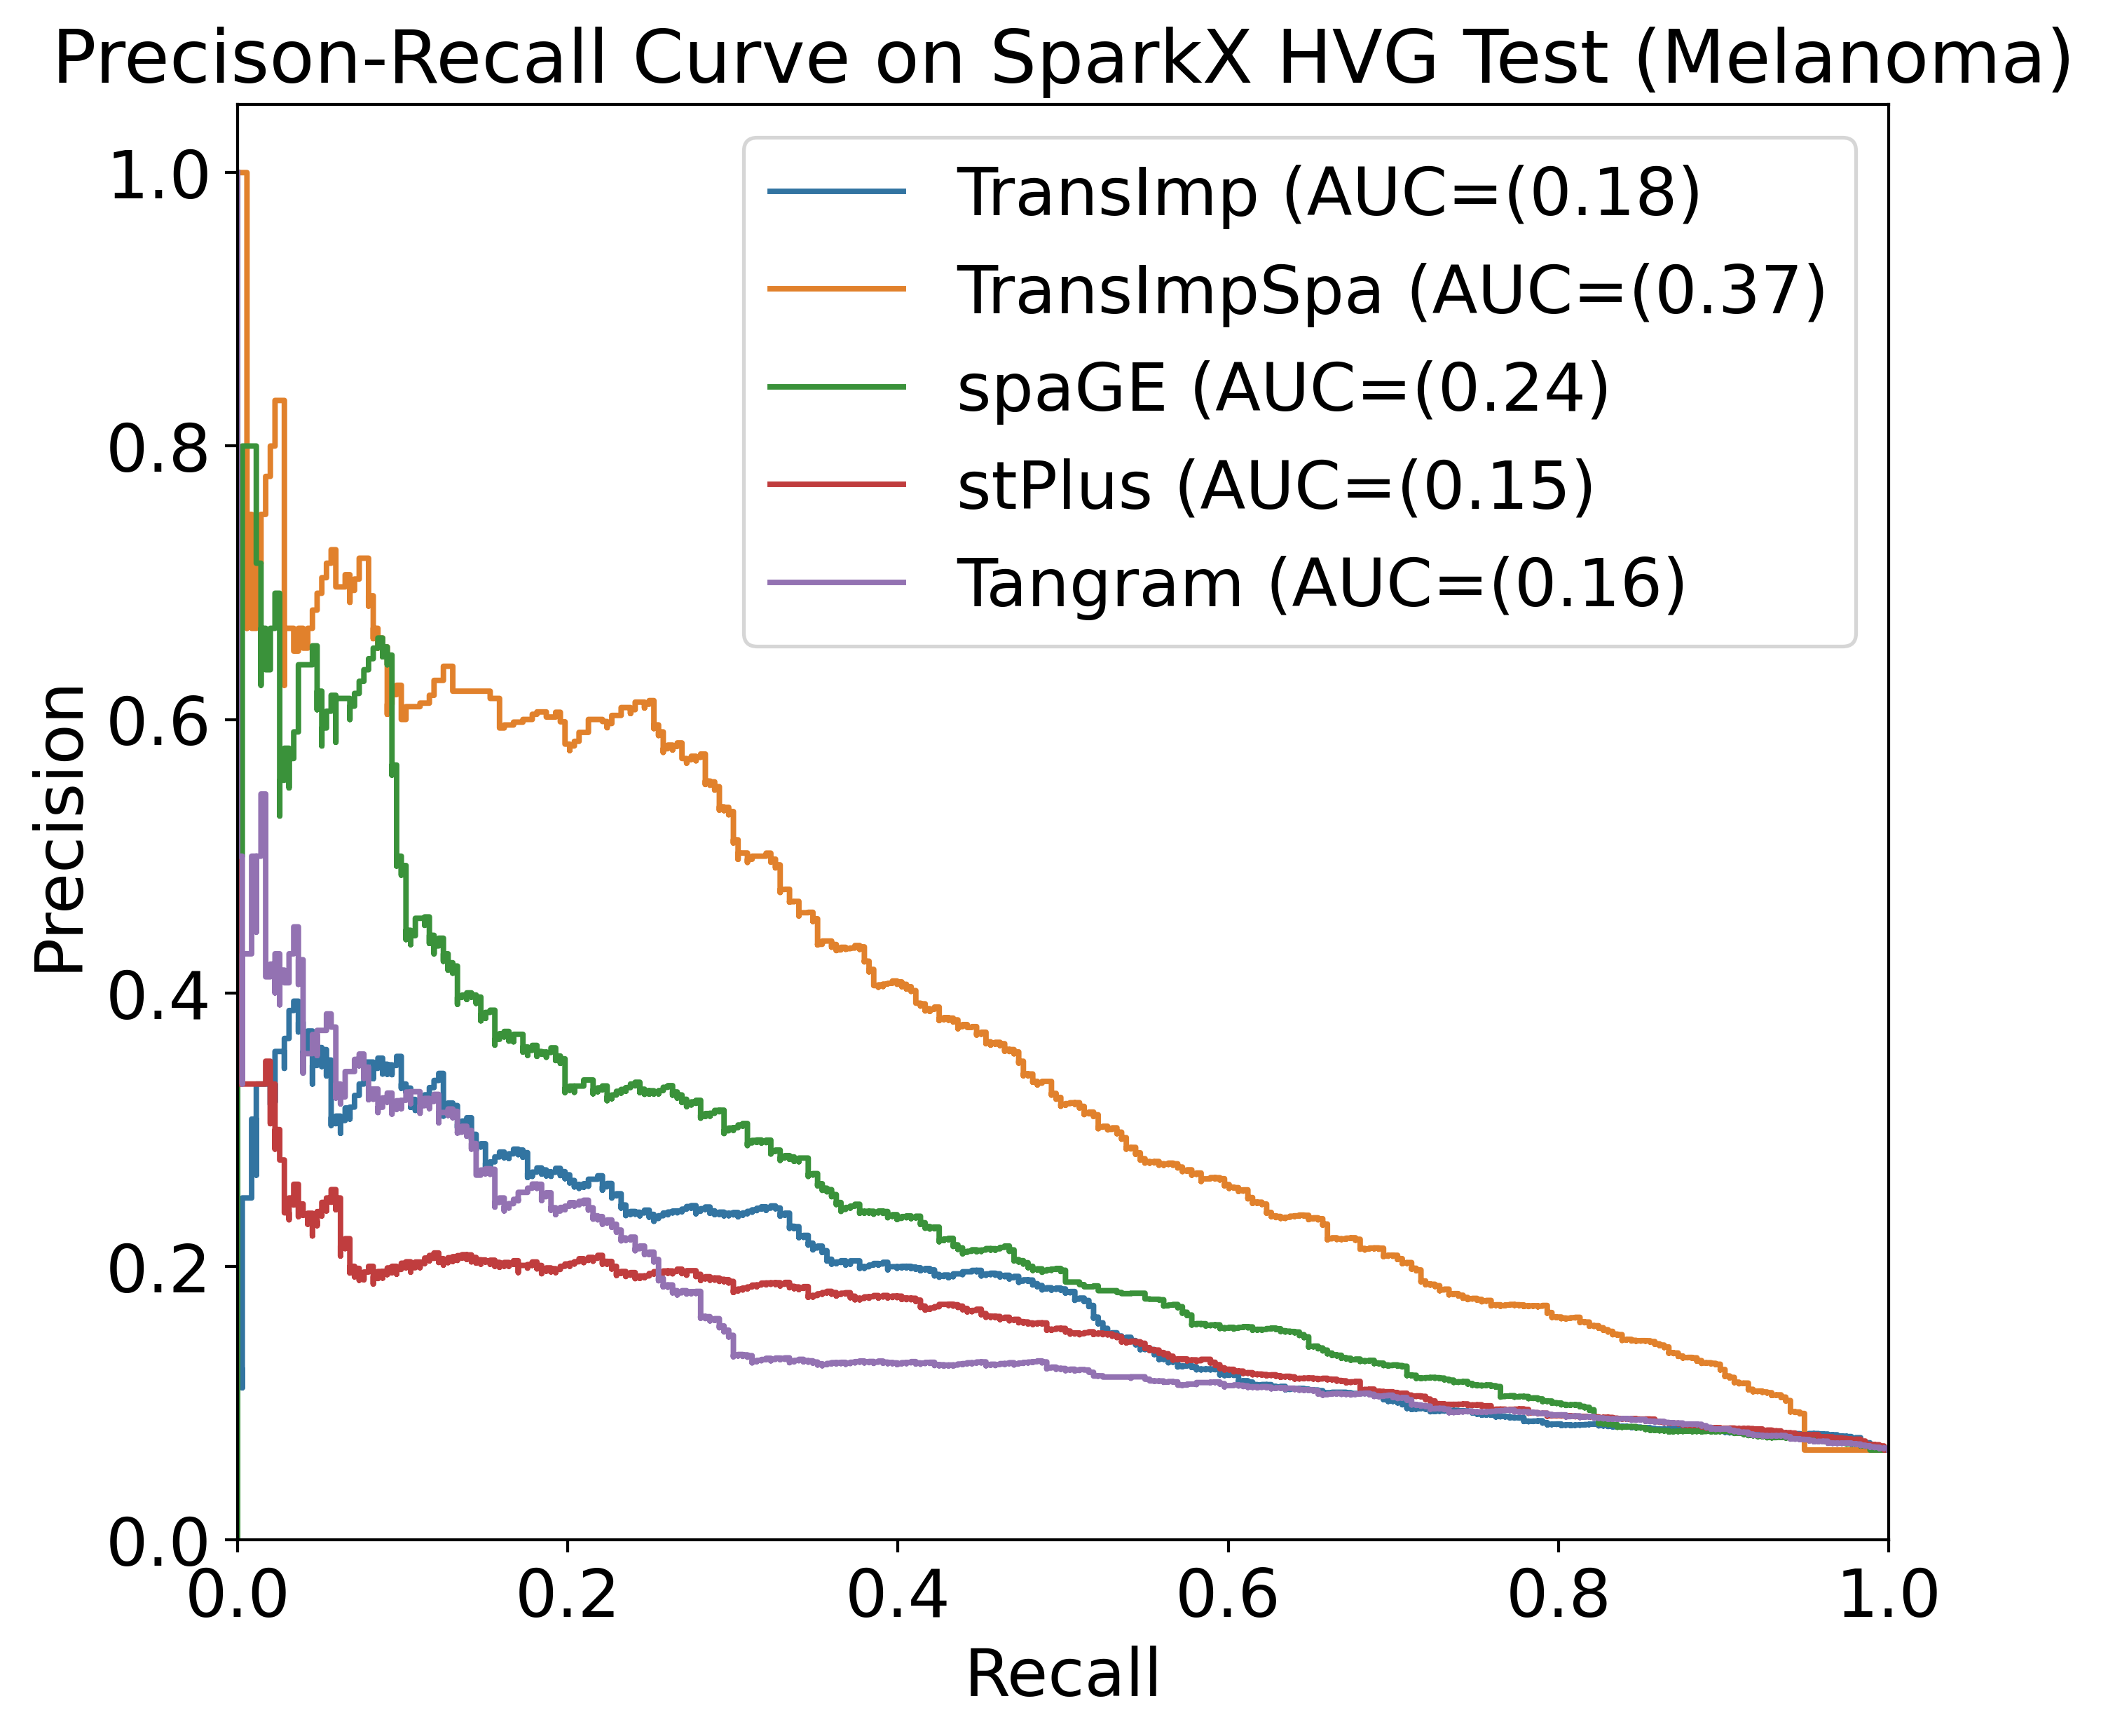

TransImp # 567 pairs, # sig pairs: (Truth): 142, (Preds) 386
TransImpSpa # 567 pairs, # sig pairs: (Truth): 142, (Preds) 329
TransImpCls # 567 pairs, # sig pairs: (Truth): 142, (Preds) 366
TransImpClsSpa # 567 pairs, # sig pairs: (Truth): 142, (Preds) 377
spaGE # 567 pairs, # sig pairs: (Truth): 142, (Preds) 367
stPlus # 567 pairs, # sig pairs: (Truth): 142, (Preds) 332
Tangram # 567 pairs, # sig pairs: (Truth): 142, (Preds) 364
truth # 567 pairs, # sig pairs: (Truth): 142, (Preds) 142


/tmp/ipykernel_4124788/3741029158.py:139: RuntimeWarning: divide by zero encountered in log
  score =  - np.log(m_adatas[method].uns['global_res'].loc[genes].fdr.values + min(np.min(m_adatas[method].uns['global_res'].loc[genes].fdr.values)/1000, 1e-500))
/tmp/ipykernel_4124788/3741029158.py:139: RuntimeWarning: divide by zero encountered in log
  score =  - np.log(m_adatas[method].uns['global_res'].loc[genes].fdr.values + min(np.min(m_adatas[method].uns['global_res'].loc[genes].fdr.values)/1000, 1e-500))


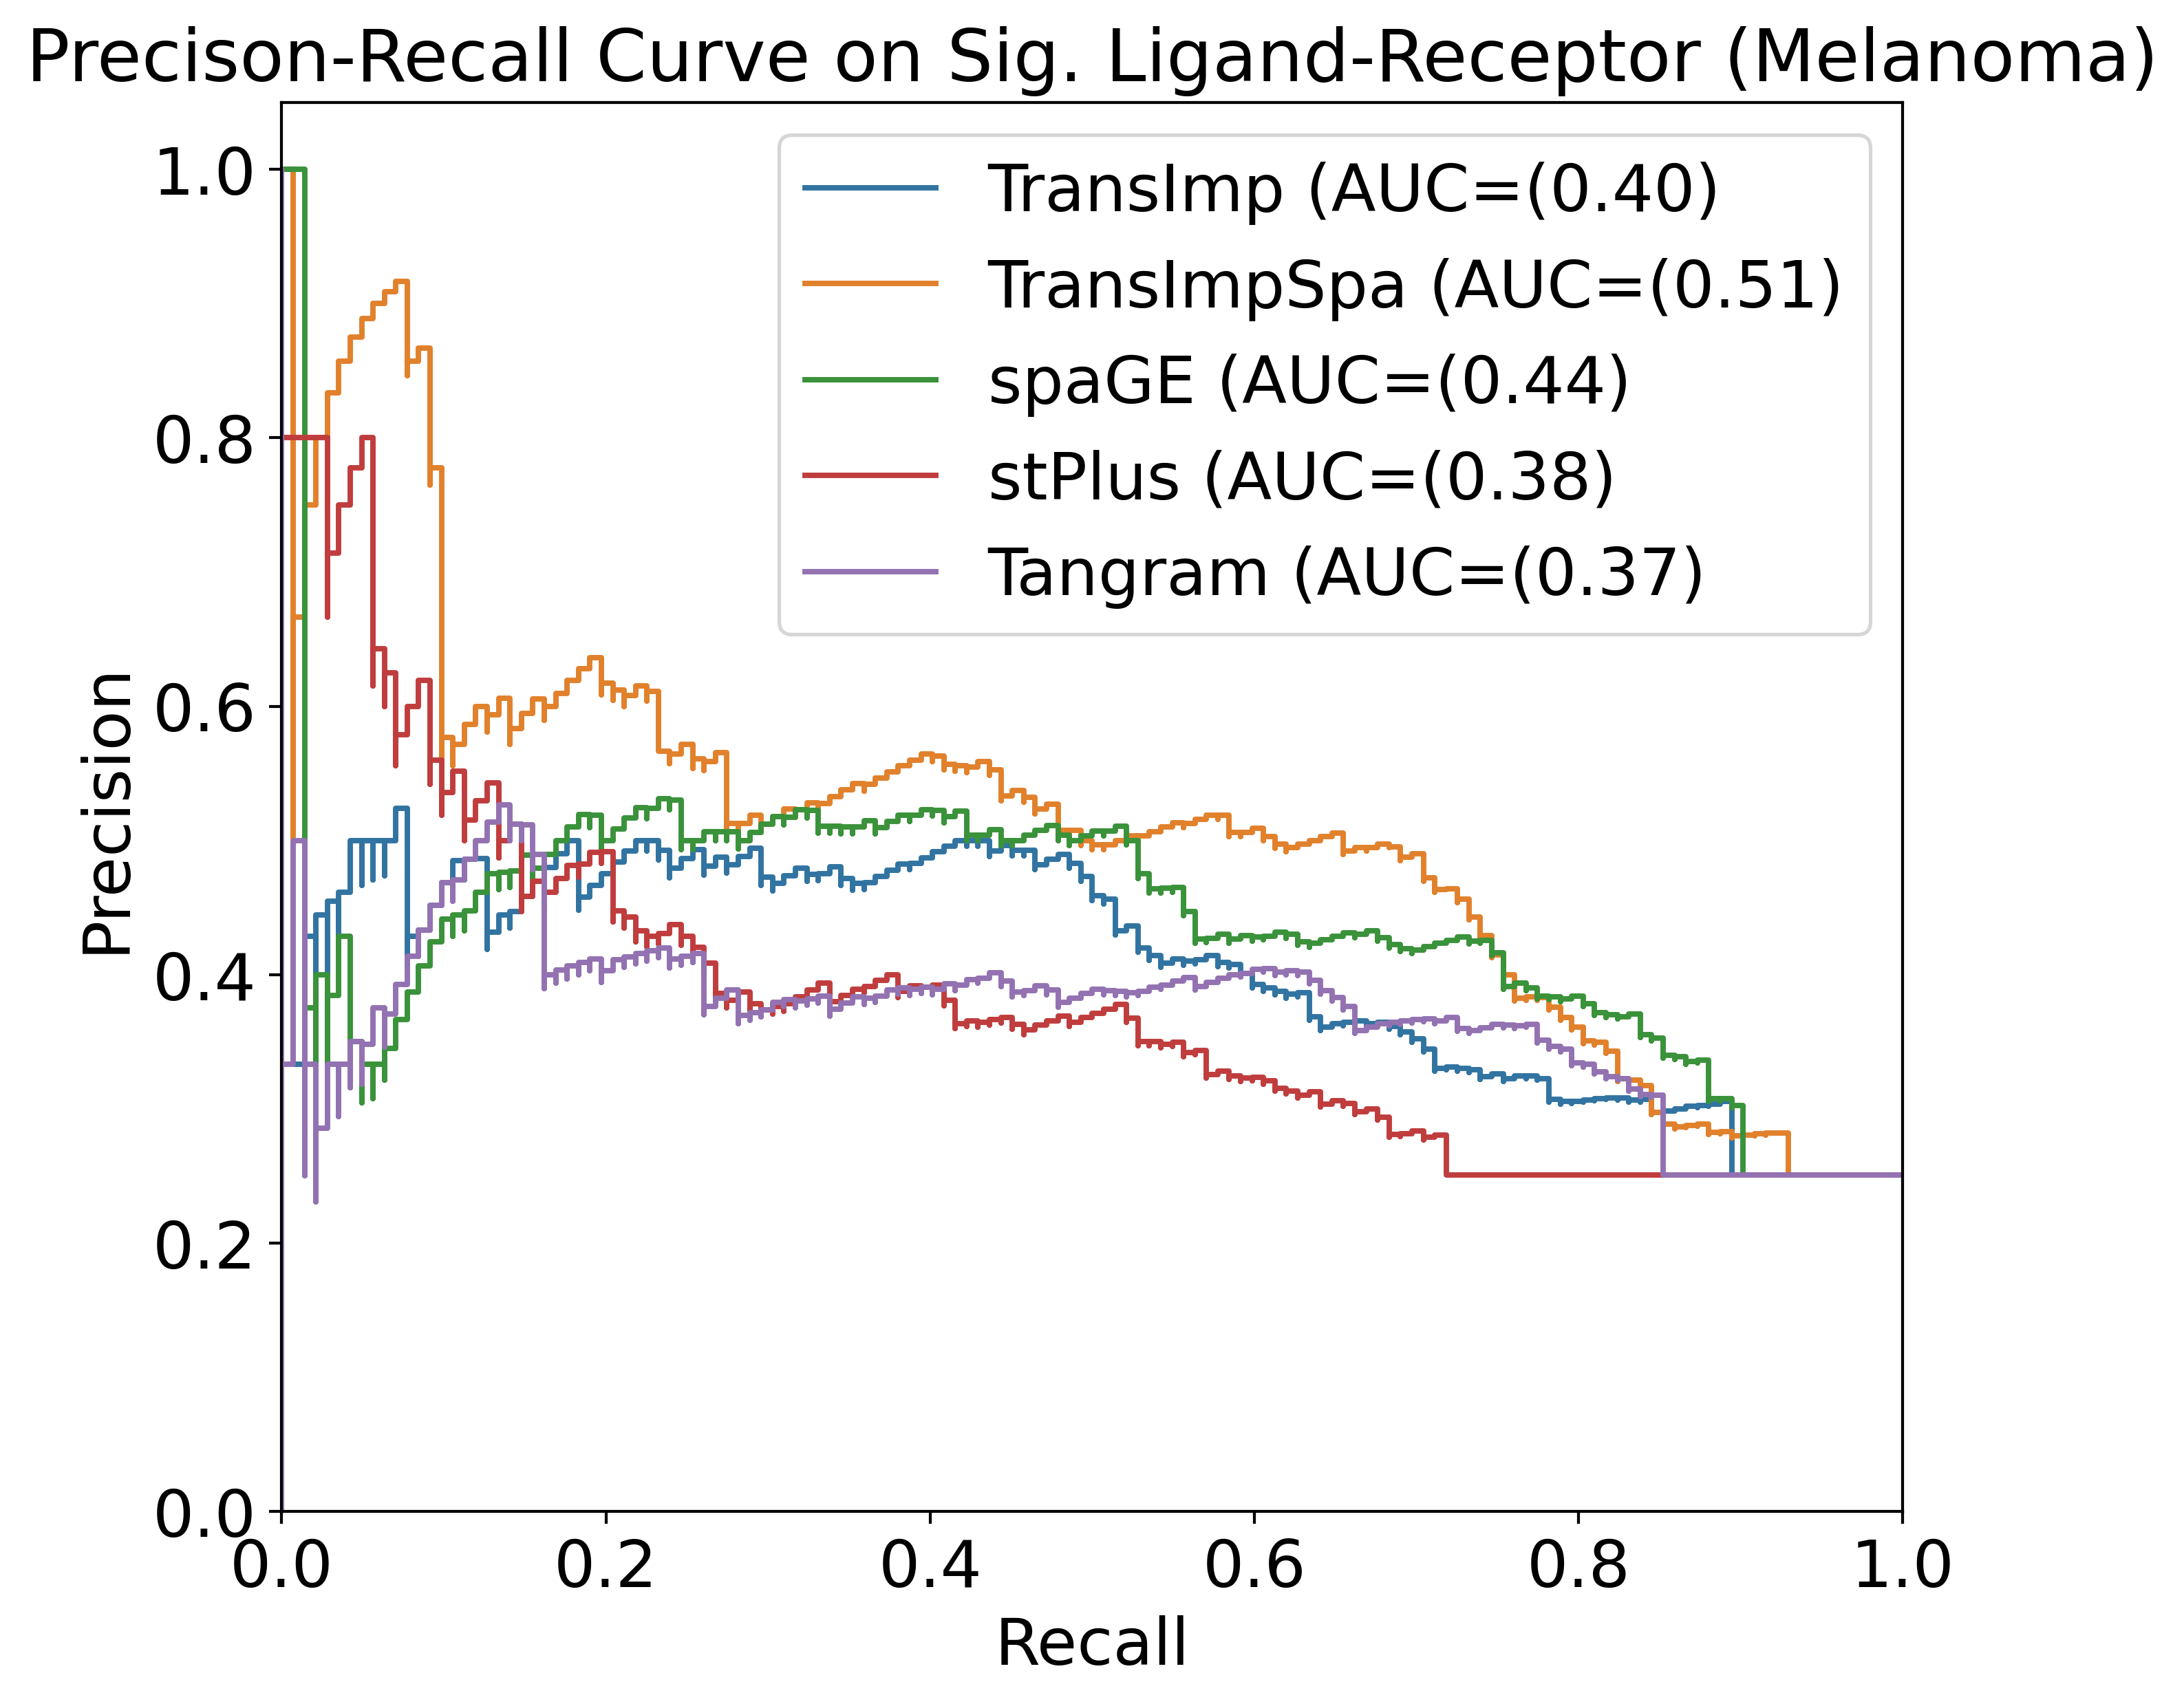

0.2623082110140132 0.37423798166517075
(TransImp) Valid genes: 5512/6852, Ground Sig/Total (3634/5512), Pred Sig/total (5512/5512)
0.24775734213222822 0.3649158669679707
(TransImpSpa) Valid genes: 5512/6852, Ground Sig/Total (3634/5512), Pred Sig/total (3693/5512)
0.272269068223871 0.38058884824848005
(TransImpCls) Valid genes: 5512/6852, Ground Sig/Total (3634/5512), Pred Sig/total (5512/5512)
0.2646769761742365 0.3757607821363491
(TransImpClsSpa) Valid genes: 5512/6852, Ground Sig/Total (3634/5512), Pred Sig/total (4968/5512)
0.24722226036086875 0.392472642895636
(spaGE) Valid genes: 5512/6852, Ground Sig/Total (3634/5512), Pred Sig/total (5437/5512)
0.23084359420638206 0.3919398241162325
(stPlus) Valid genes: 5512/6852, Ground Sig/Total (3634/5512), Pred Sig/total (0/5512)
0.2696443713393144 0.38052231718122176
(Tangram) Valid genes: 5512/6852, Ground Sig/Total (3634/5512), Pred Sig/total (5512/5512)
1.0 1.0
(truth) Valid genes: 5512/6852, Ground Sig/Total (3634/5512), Pred Sig/tota

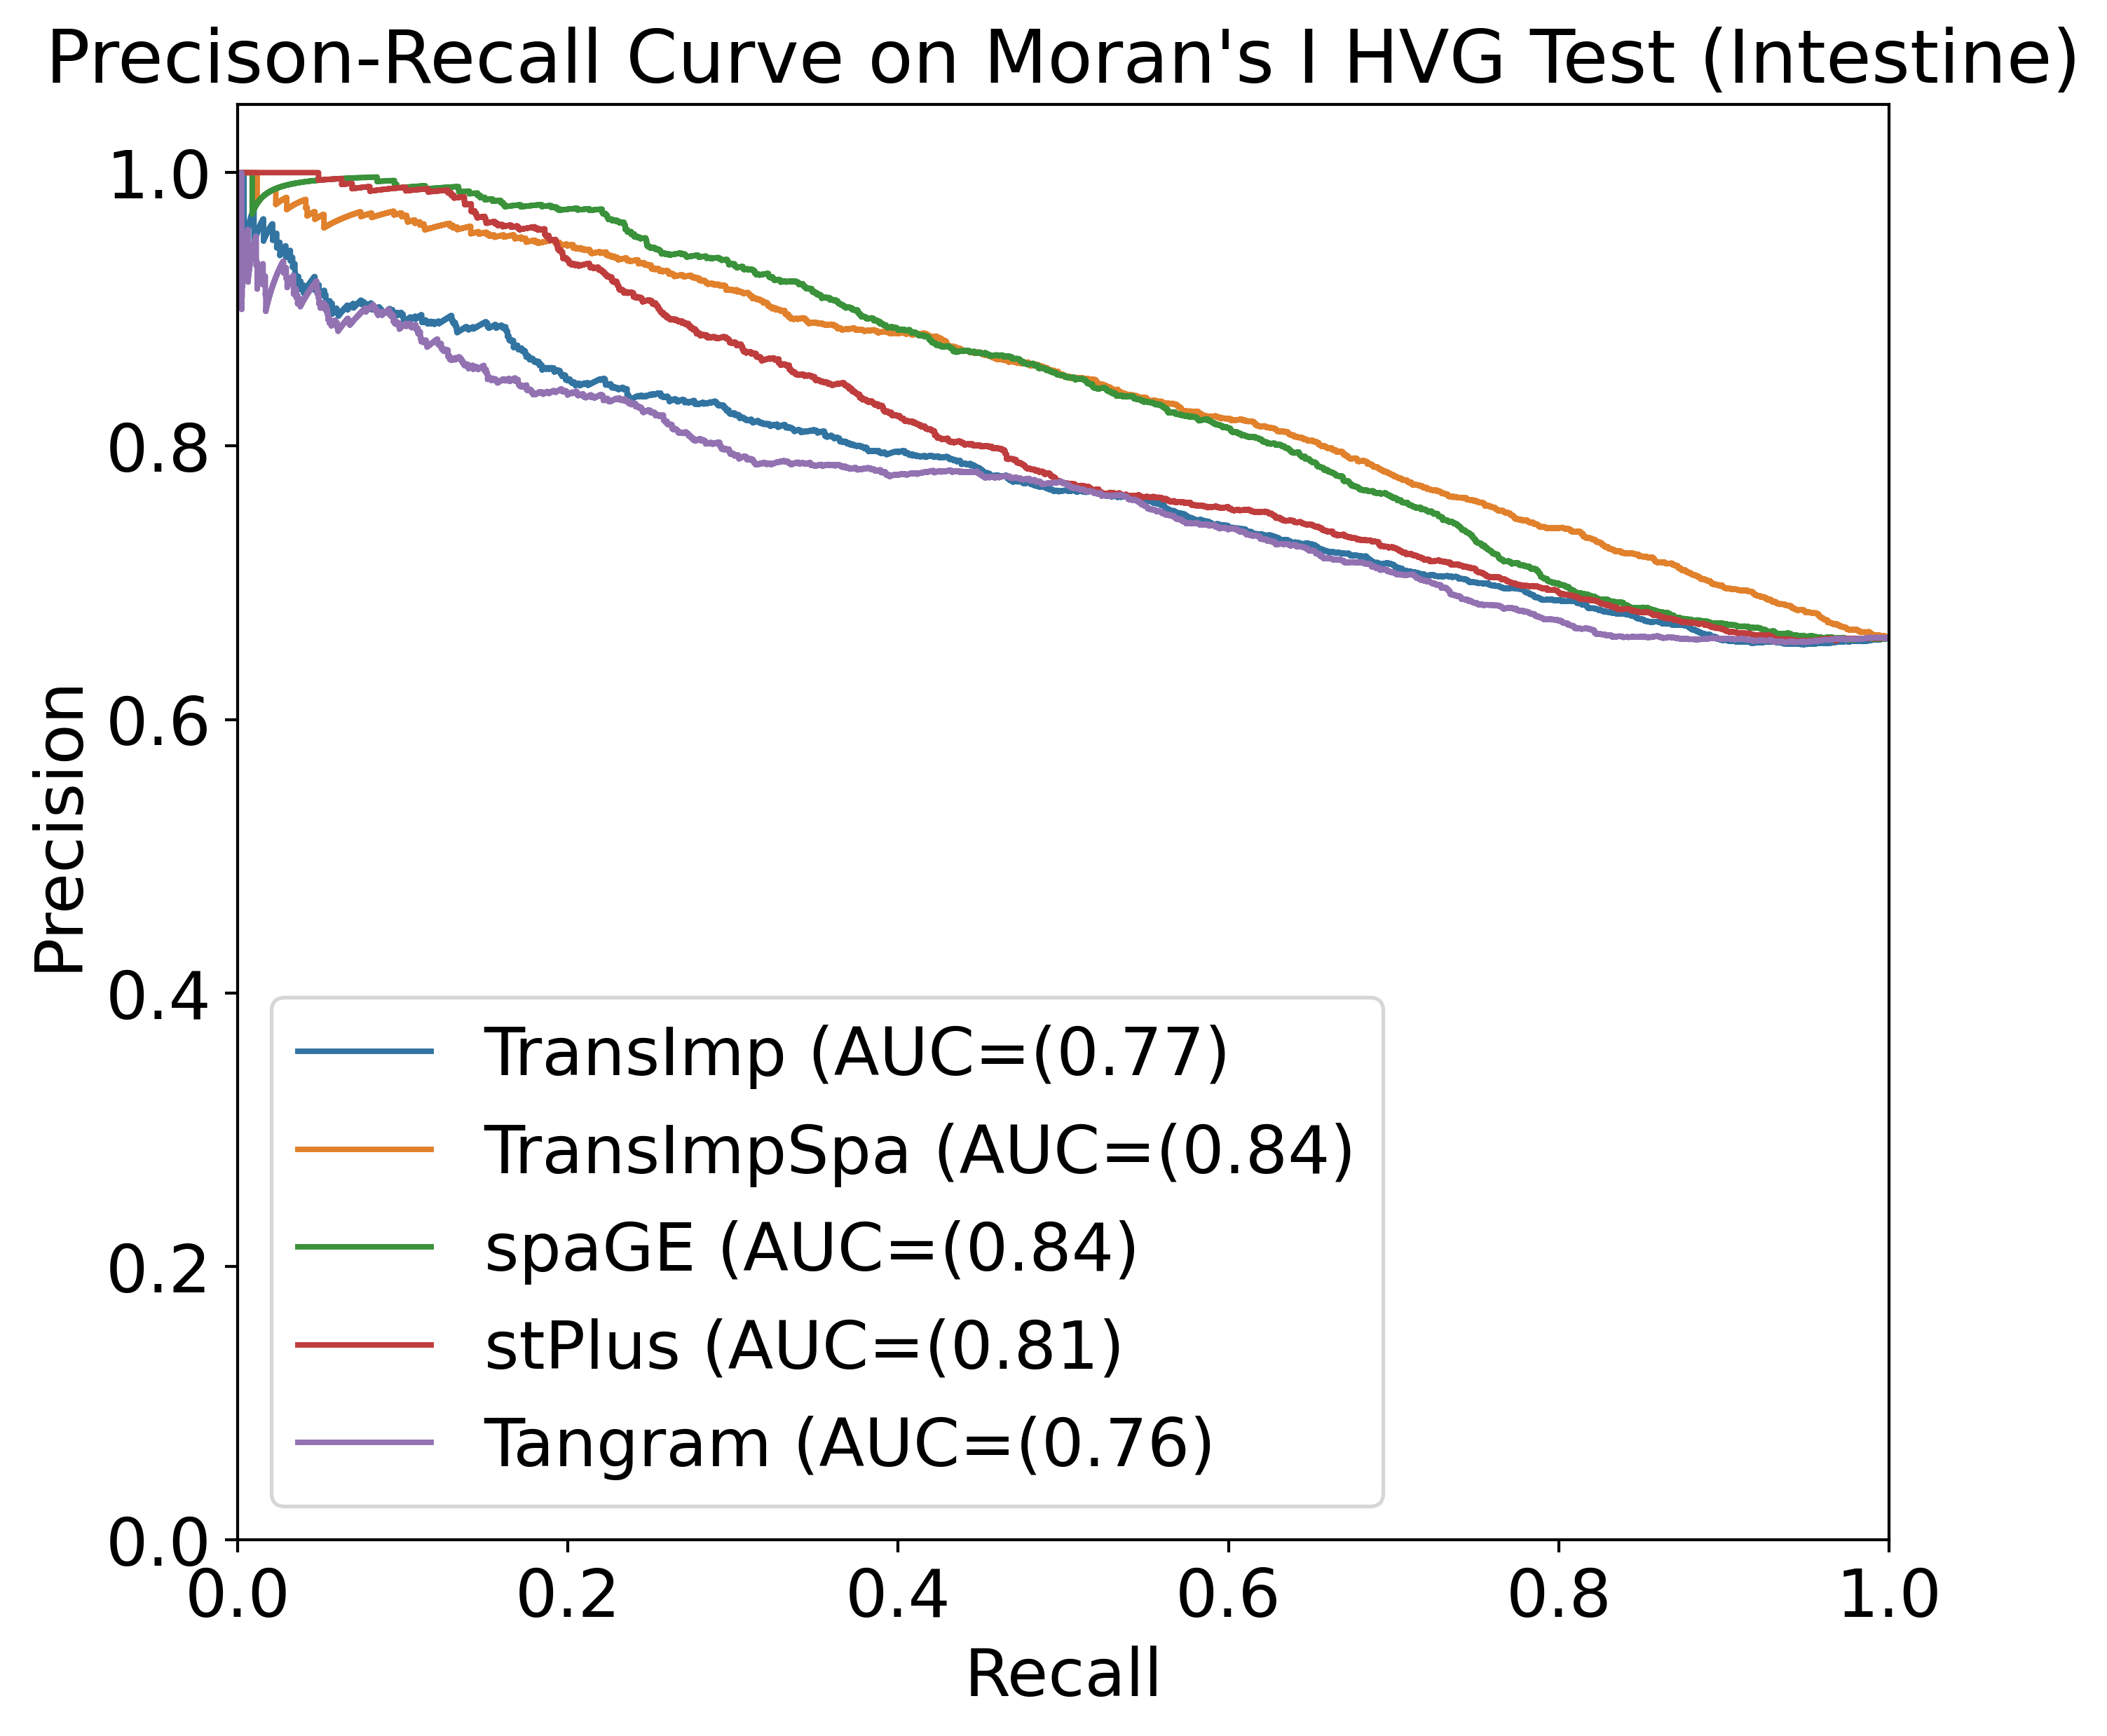

(TransImp) Valid genes: 6852/6852
(TransImpSpa) Valid genes: 6852/6852
(TransImpCls) Valid genes: 6852/6852
(TransImpClsSpa) Valid genes: 6852/6852
(spaGE) Valid genes: 6852/6852
(stPlus) Valid genes: 6852/6852
(Tangram) Valid genes: 6852/6852
(truth) Valid genes: 6852/6852


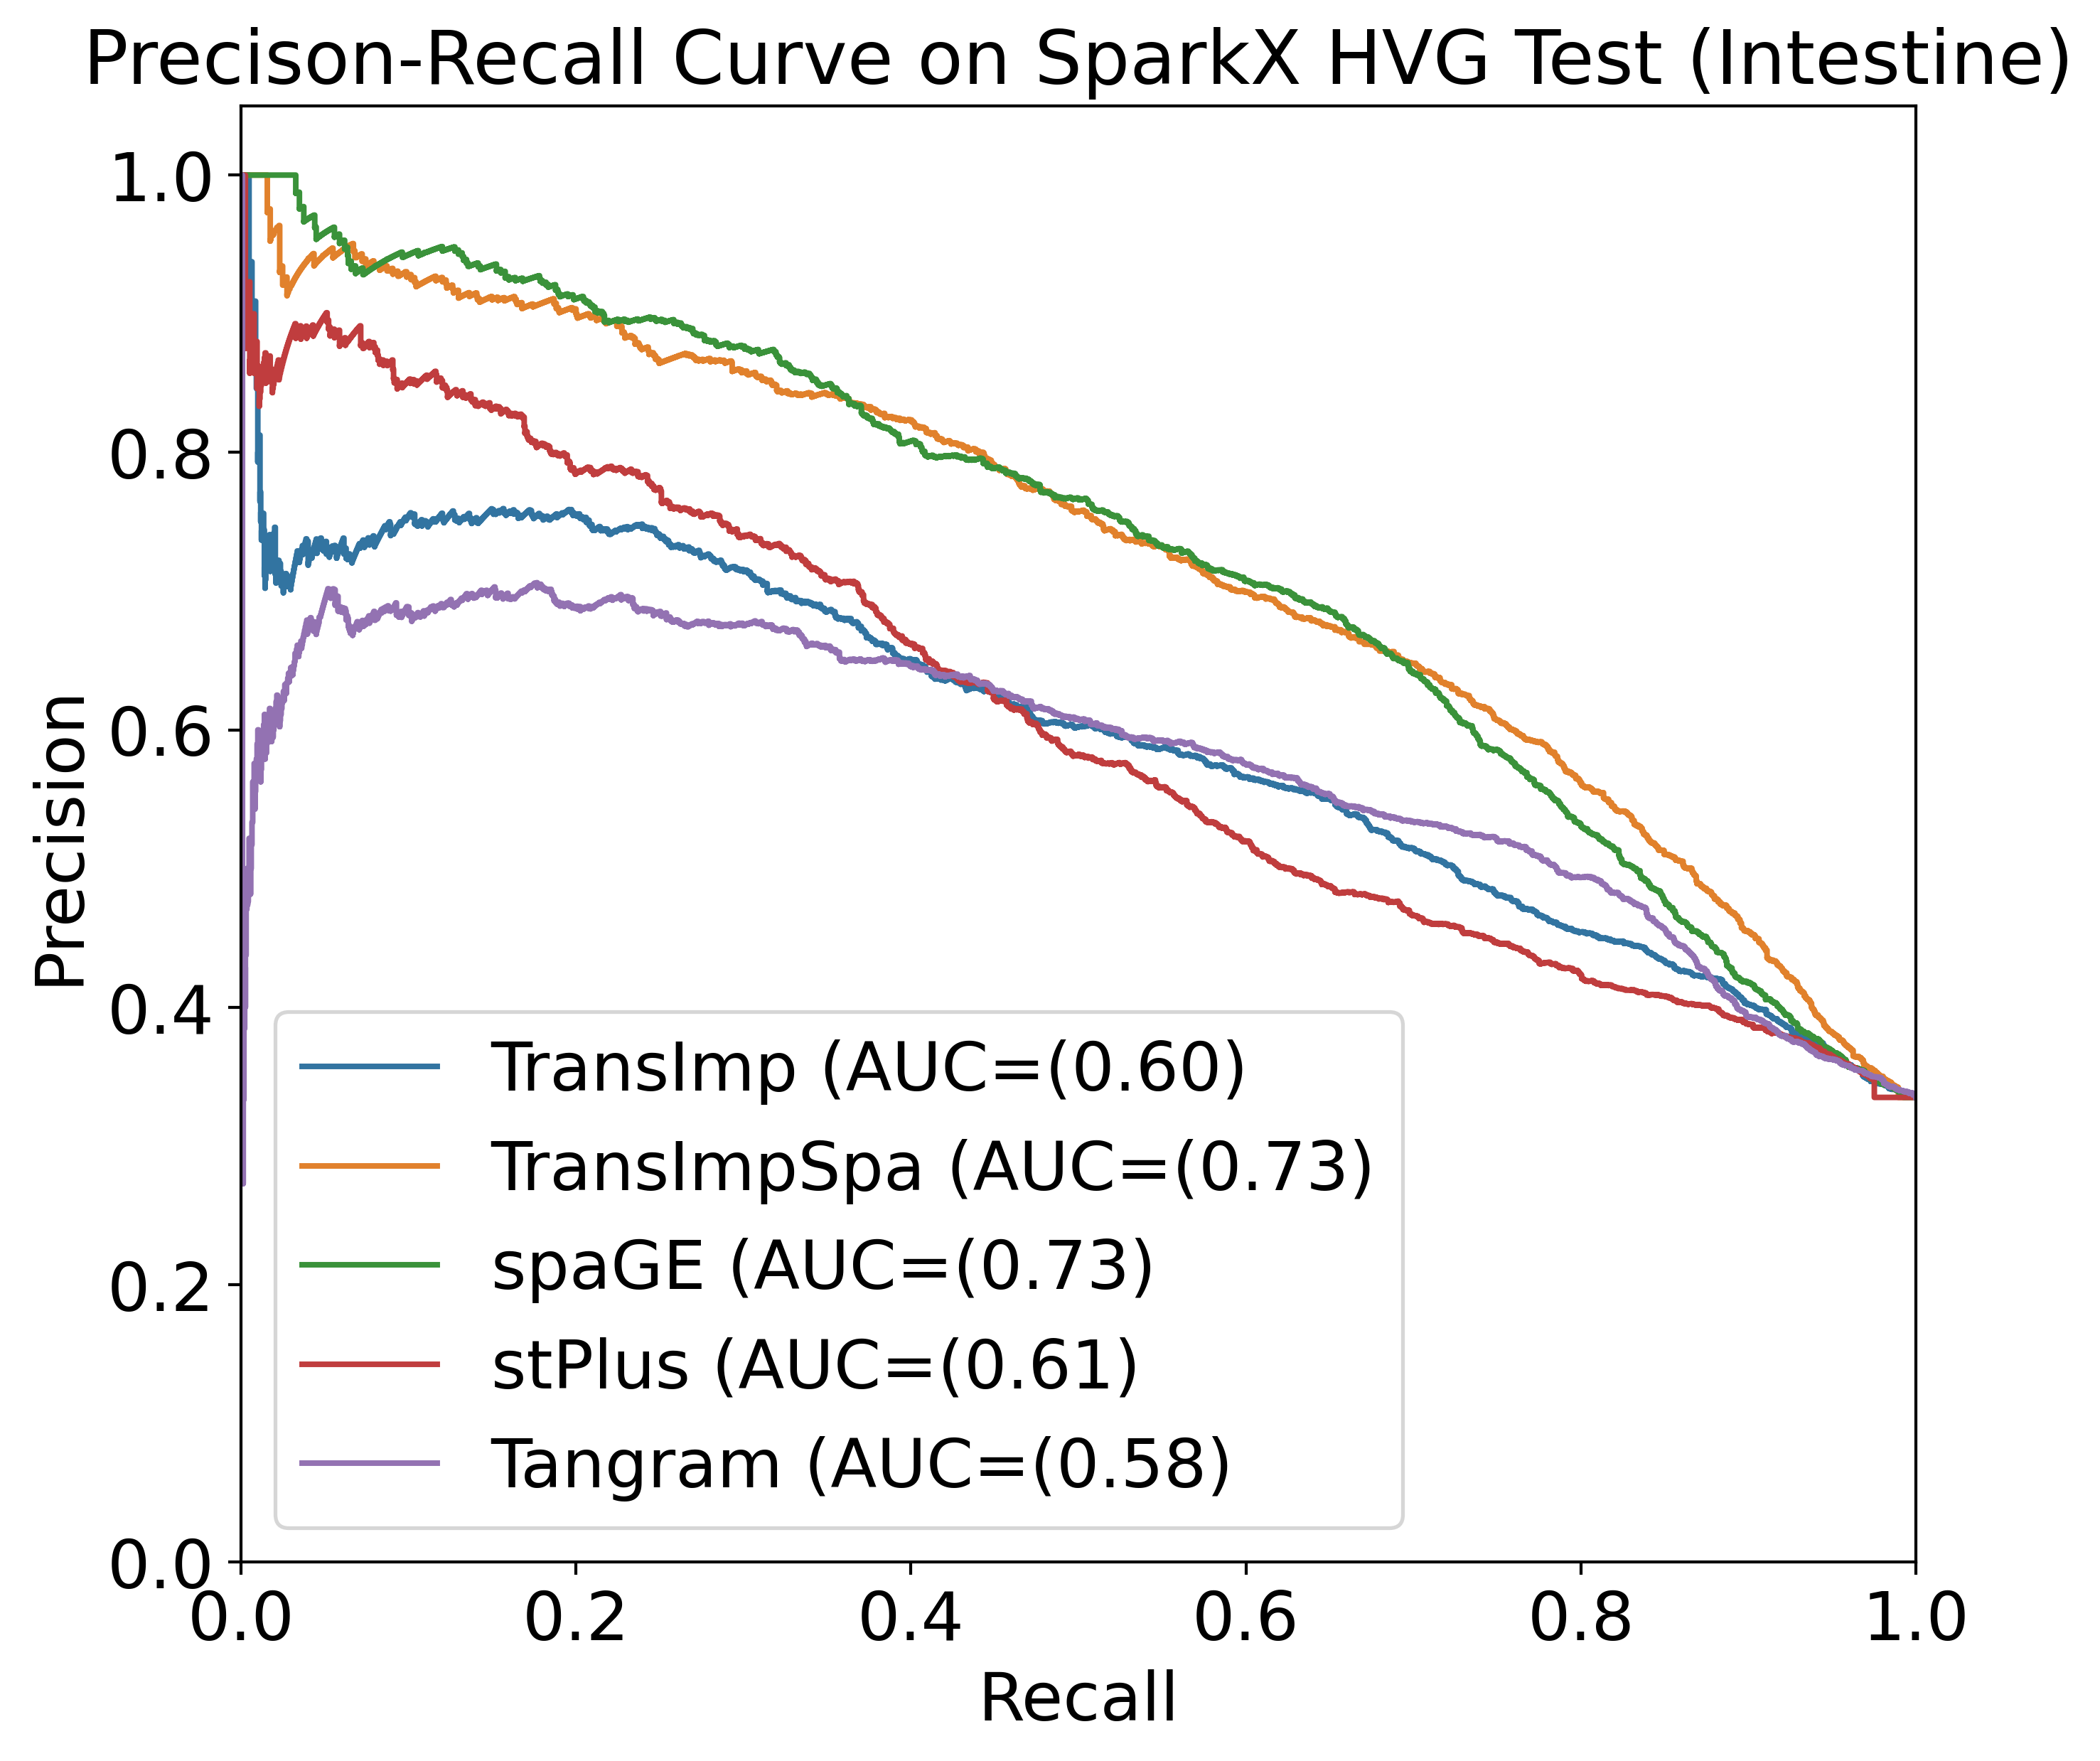

TransImp # 1396 pairs, # sig pairs: (Truth): 282, (Preds) 697
TransImpSpa # 1396 pairs, # sig pairs: (Truth): 282, (Preds) 524
TransImpCls # 1396 pairs, # sig pairs: (Truth): 282, (Preds) 511
TransImpClsSpa # 1396 pairs, # sig pairs: (Truth): 282, (Preds) 523
spaGE # 1396 pairs, # sig pairs: (Truth): 282, (Preds) 384
stPlus # 1396 pairs, # sig pairs: (Truth): 282, (Preds) 313
Tangram # 1396 pairs, # sig pairs: (Truth): 282, (Preds) 659
truth # 1396 pairs, # sig pairs: (Truth): 282, (Preds) 282


/tmp/ipykernel_4124788/3741029158.py:139: RuntimeWarning: divide by zero encountered in log
  score =  - np.log(m_adatas[method].uns['global_res'].loc[genes].fdr.values + min(np.min(m_adatas[method].uns['global_res'].loc[genes].fdr.values)/1000, 1e-500))
/tmp/ipykernel_4124788/3741029158.py:139: RuntimeWarning: divide by zero encountered in log
  score =  - np.log(m_adatas[method].uns['global_res'].loc[genes].fdr.values + min(np.min(m_adatas[method].uns['global_res'].loc[genes].fdr.values)/1000, 1e-500))
/tmp/ipykernel_4124788/3741029158.py:139: RuntimeWarning: divide by zero encountered in log
  score =  - np.log(m_adatas[method].uns['global_res'].loc[genes].fdr.values + min(np.min(m_adatas[method].uns['global_res'].loc[genes].fdr.values)/1000, 1e-500))
/tmp/ipykernel_4124788/3741029158.py:139: RuntimeWarning: divide by zero encountered in log
  score =  - np.log(m_adatas[method].uns['global_res'].loc[genes].fdr.values + min(np.min(m_adatas[method].uns['global_res'].loc[genes].fdr.val

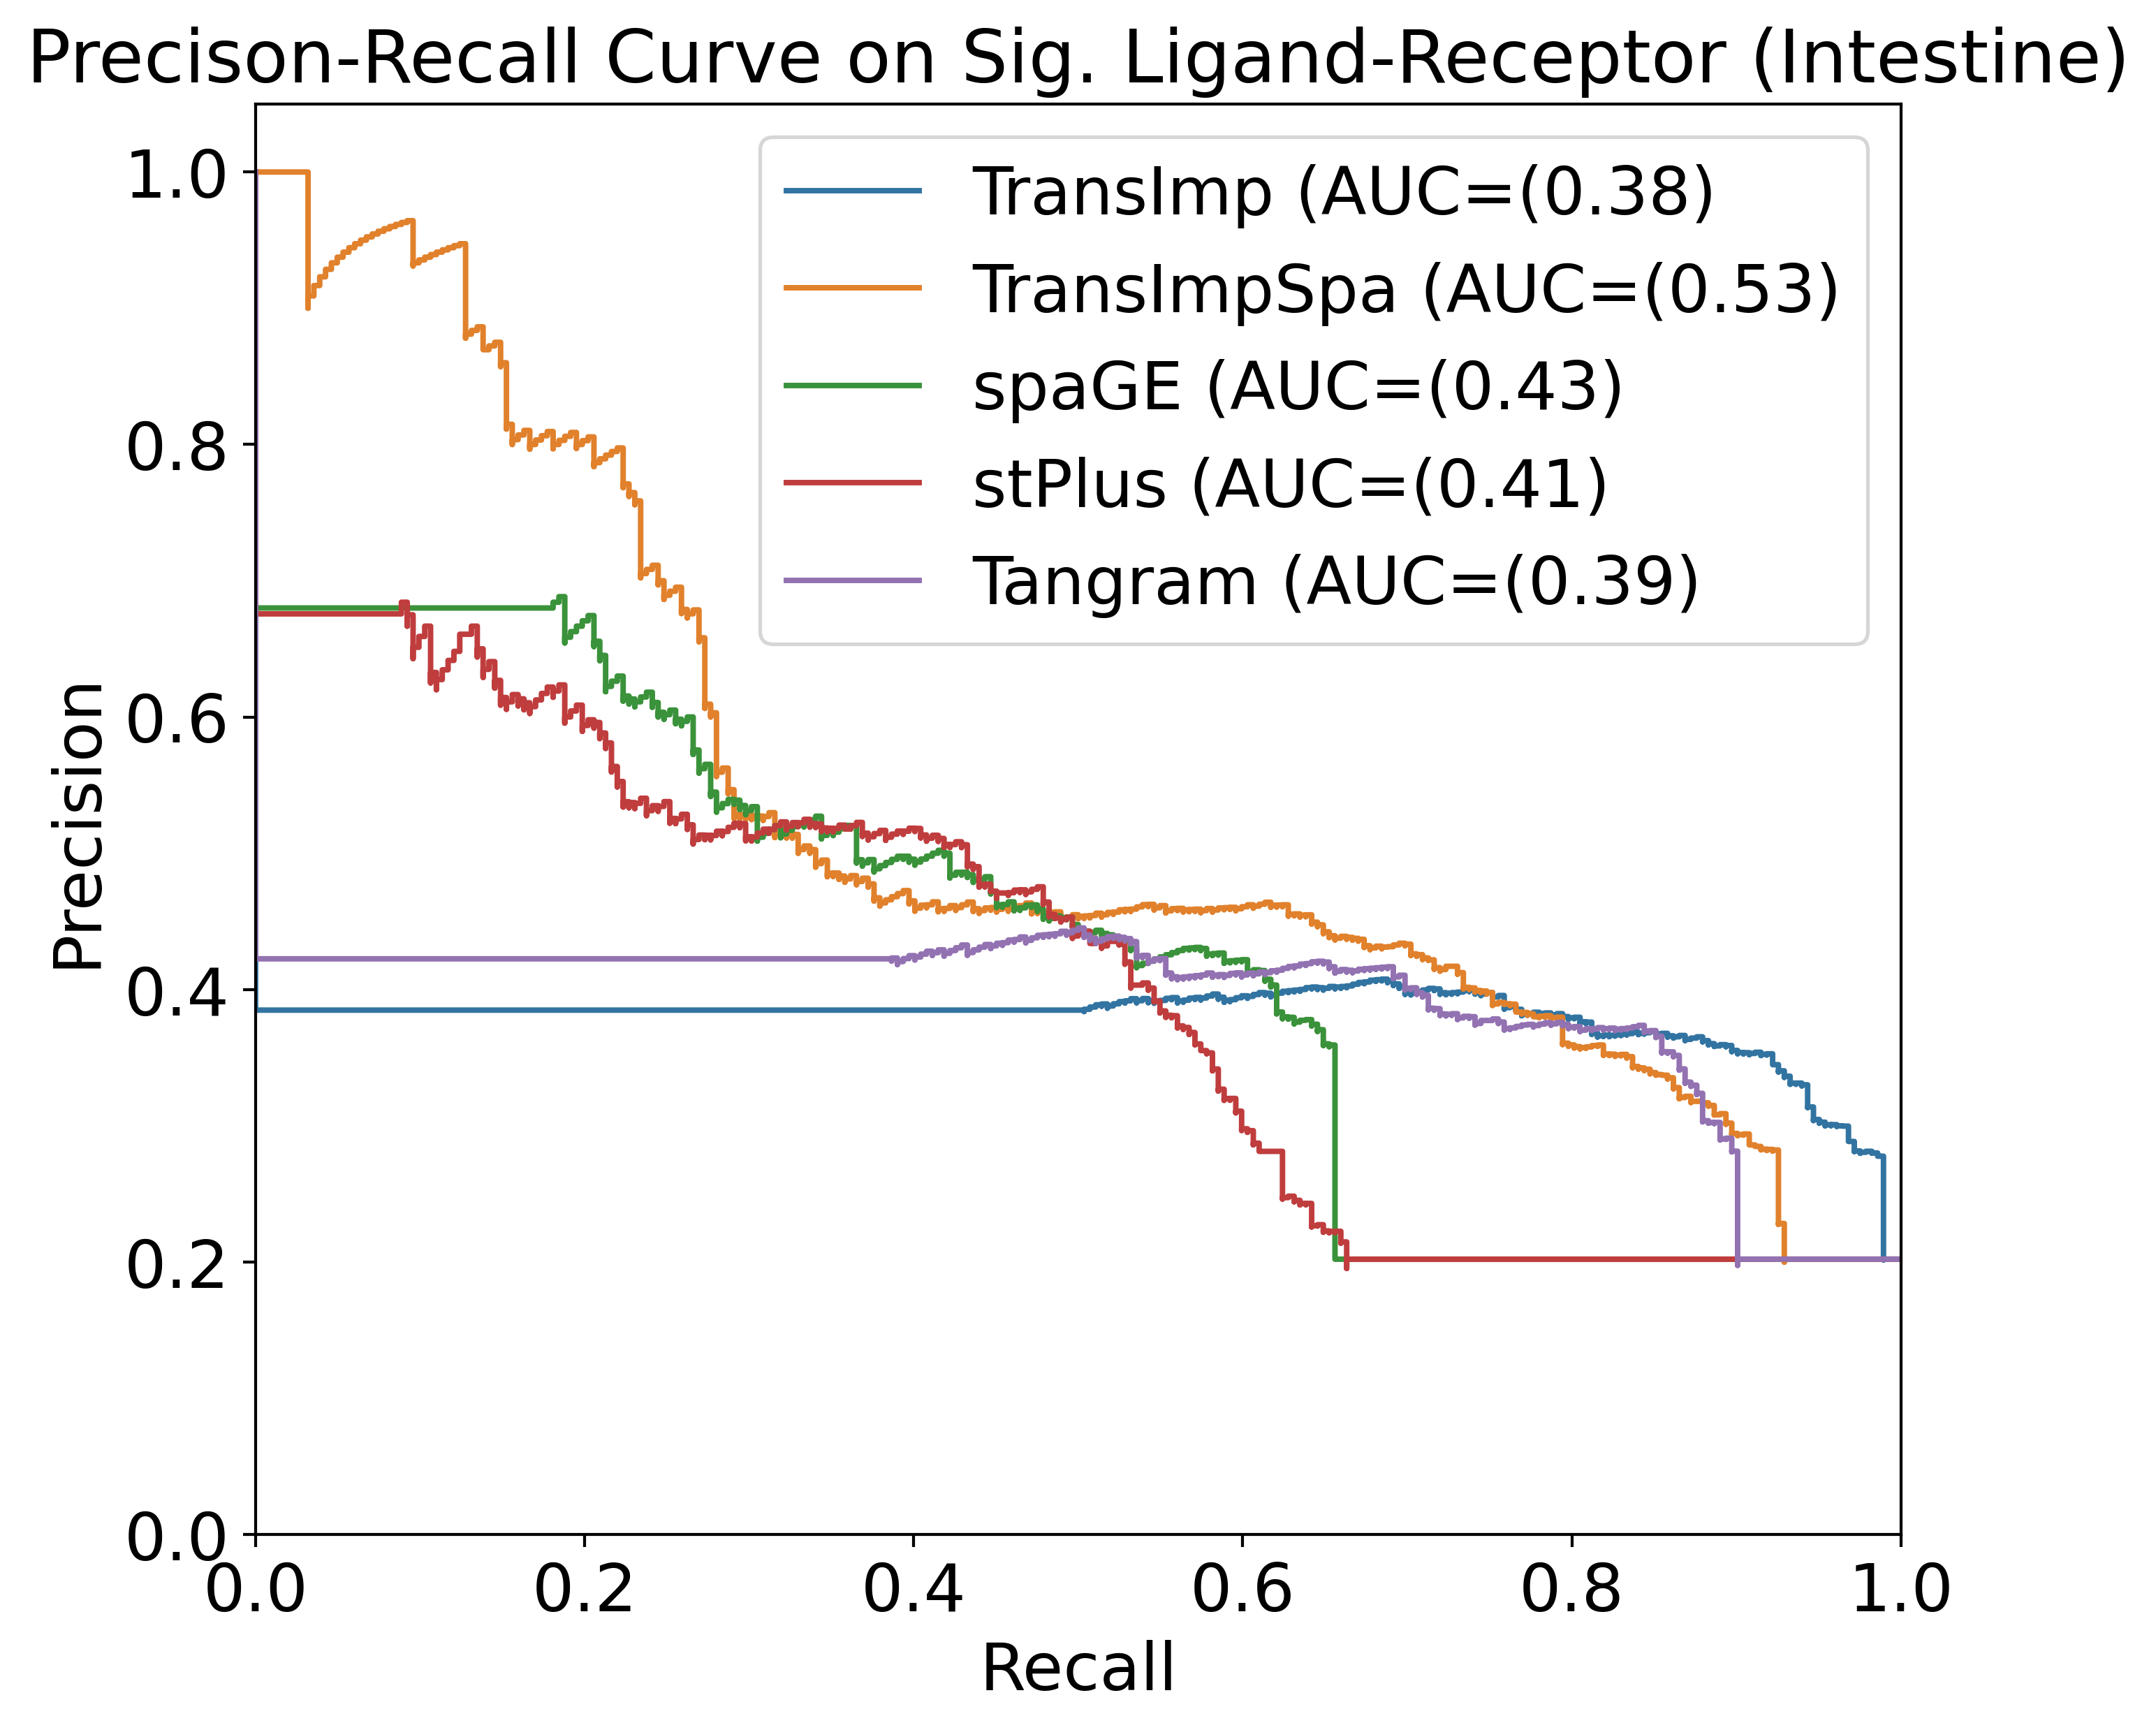

0.29439436894829385 0.3719223019037172
(TransImp) Valid genes: 3010/4241, Ground Sig/Total (921/3010), Pred Sig/total (2945/3010)
0.29444413029969885 0.37143426666506807
(TransImpSpa) Valid genes: 3010/4241, Ground Sig/Total (921/3010), Pred Sig/total (1748/3010)
0.29946108553708817 0.3739677276077519
(TransImpCls) Valid genes: 3010/4241, Ground Sig/Total (921/3010), Pred Sig/total (2997/3010)
0.2980957789695642 0.37275520025650155
(TransImpClsSpa) Valid genes: 3010/4241, Ground Sig/Total (921/3010), Pred Sig/total (1708/3010)
0.24965596164966652 0.35332710184255856
(spaGE) Valid genes: 3010/4241, Ground Sig/Total (921/3010), Pred Sig/total (2479/3010)
0.25615719955223404 0.35634370888625533
(stPlus) Valid genes: 3010/4241, Ground Sig/Total (921/3010), Pred Sig/total (0/3010)
0.296946297177887 0.3727021038600837
(Tangram) Valid genes: 3010/4241, Ground Sig/Total (921/3010), Pred Sig/total (2985/3010)
1.0 1.0
(truth) Valid genes: 3010/4241, Ground Sig/Total (921/3010), Pred Sig/total (9

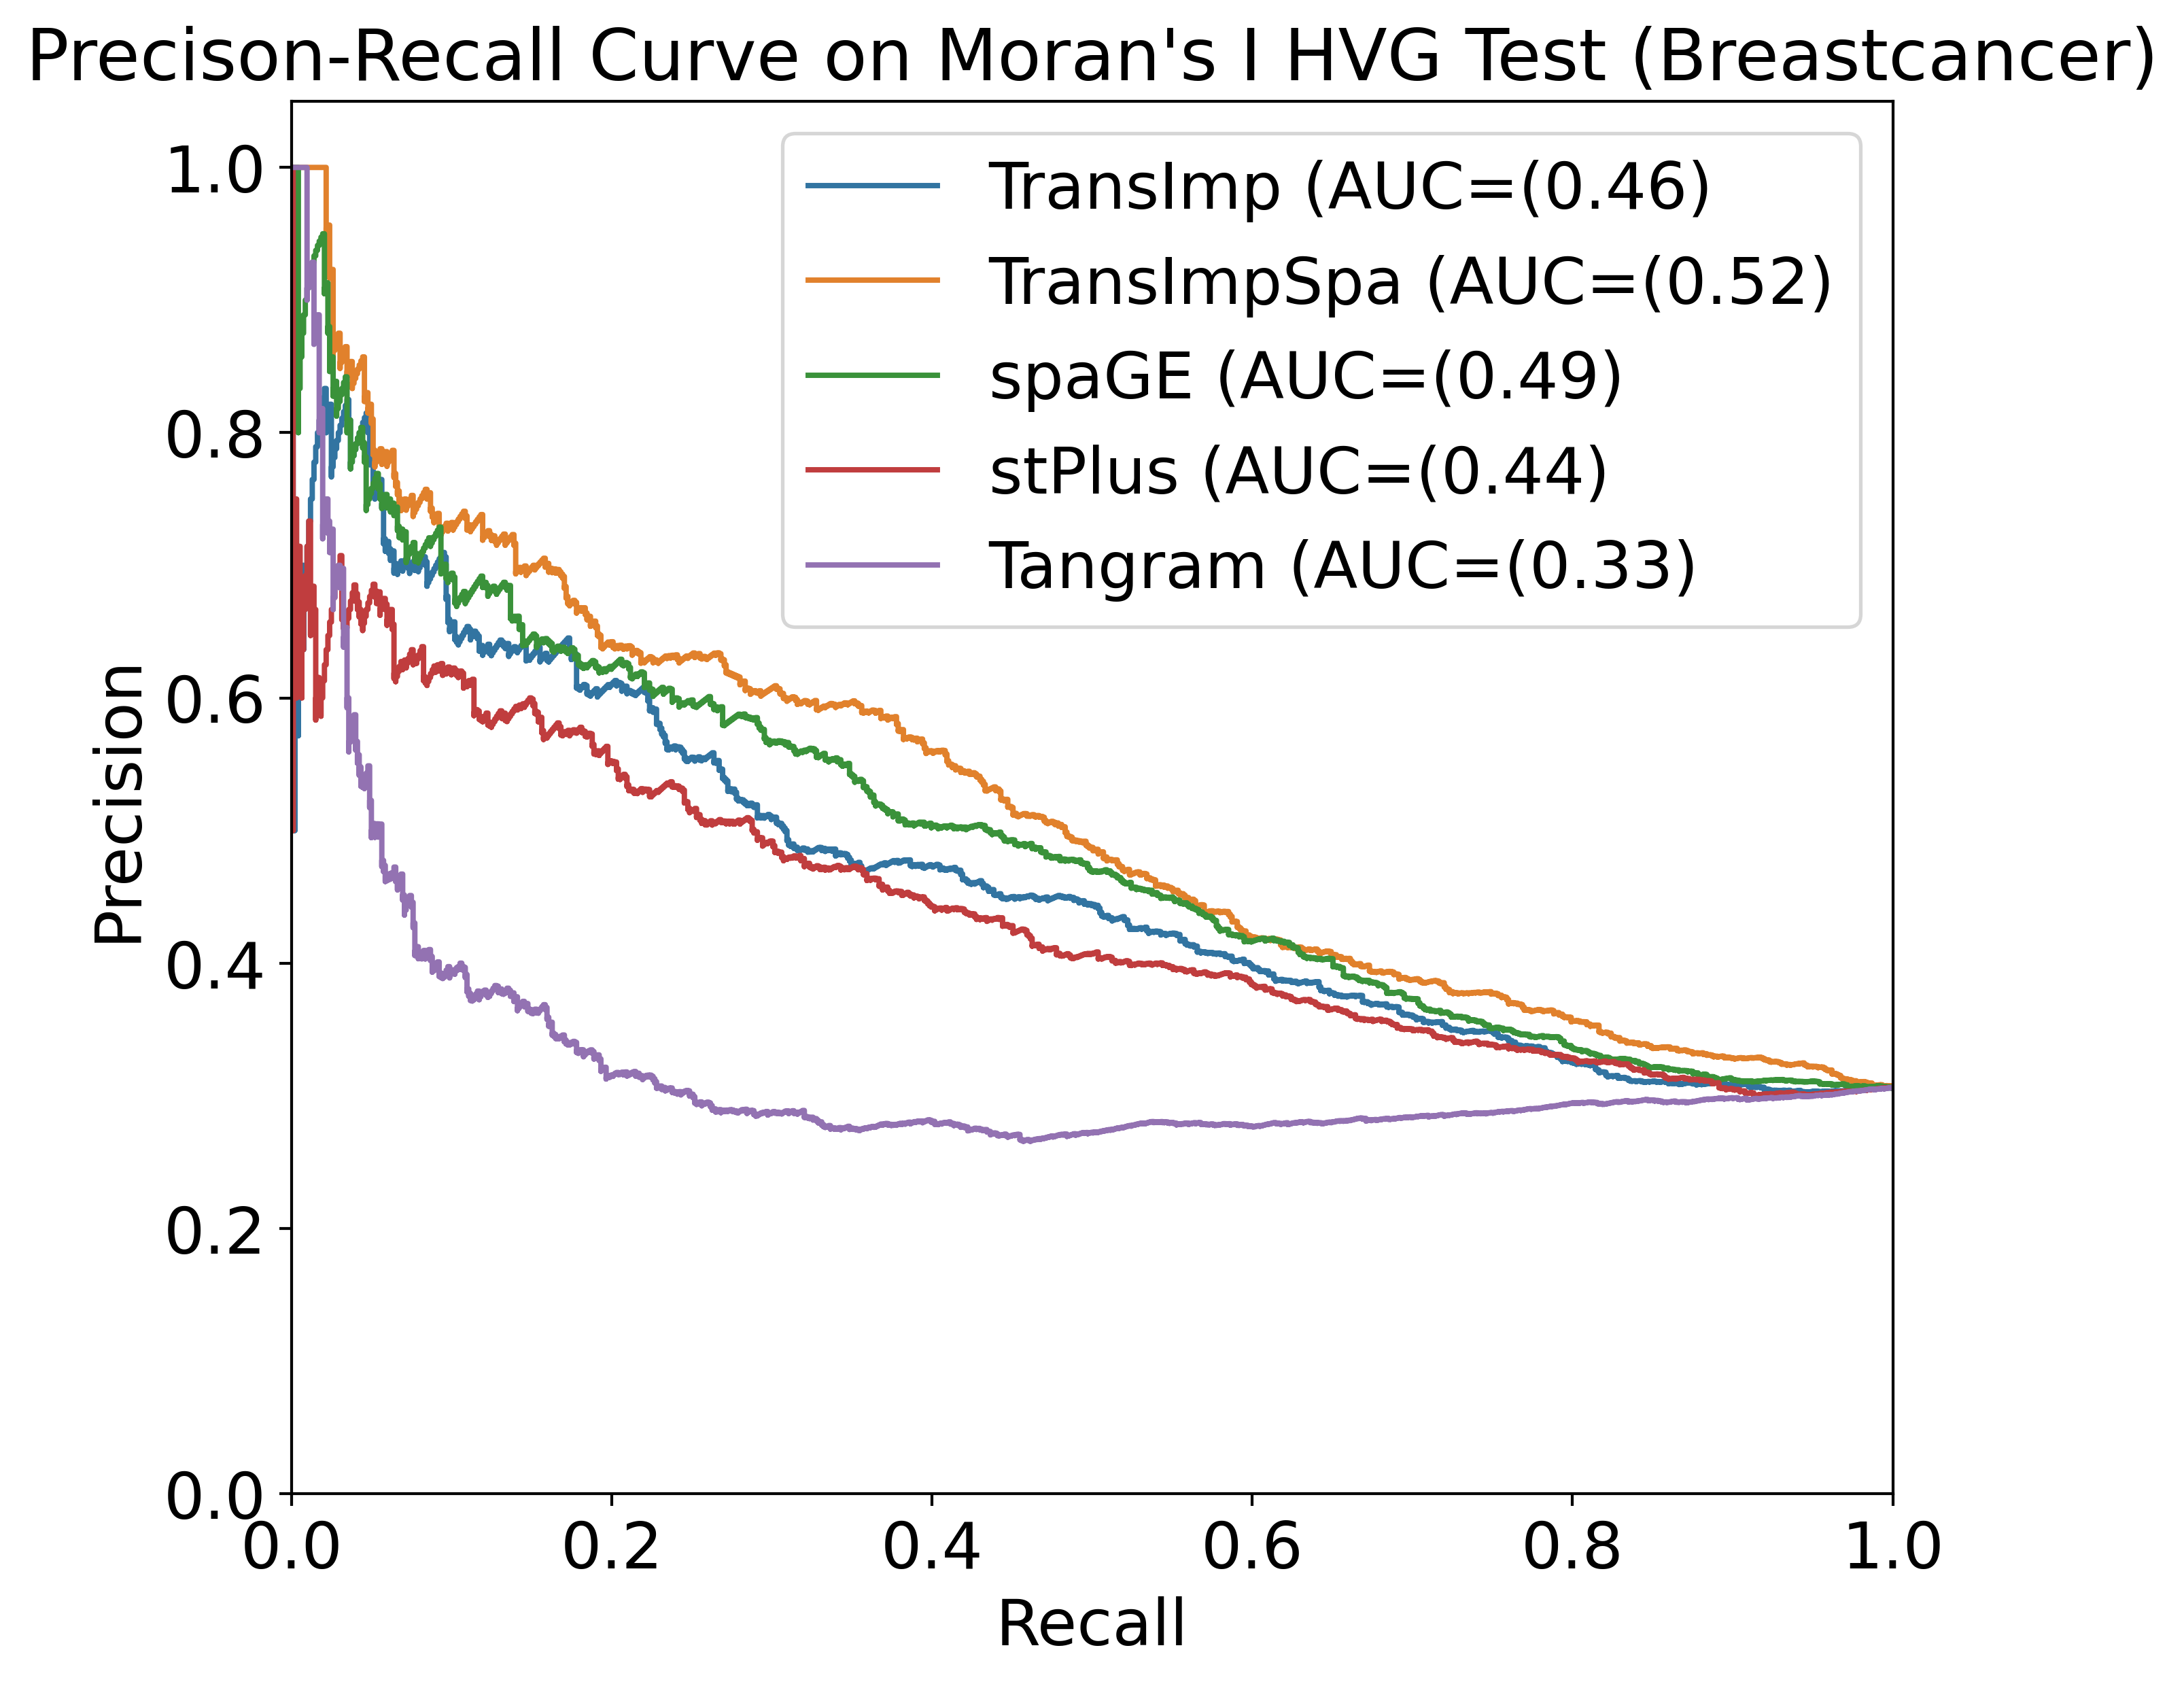

(TransImp) Valid genes: 4241/4241
(TransImpSpa) Valid genes: 4241/4241
(TransImpCls) Valid genes: 4241/4241
(TransImpClsSpa) Valid genes: 4241/4241
(spaGE) Valid genes: 4241/4241
(stPlus) Valid genes: 4241/4241
(Tangram) Valid genes: 4241/4241
(truth) Valid genes: 4241/4241


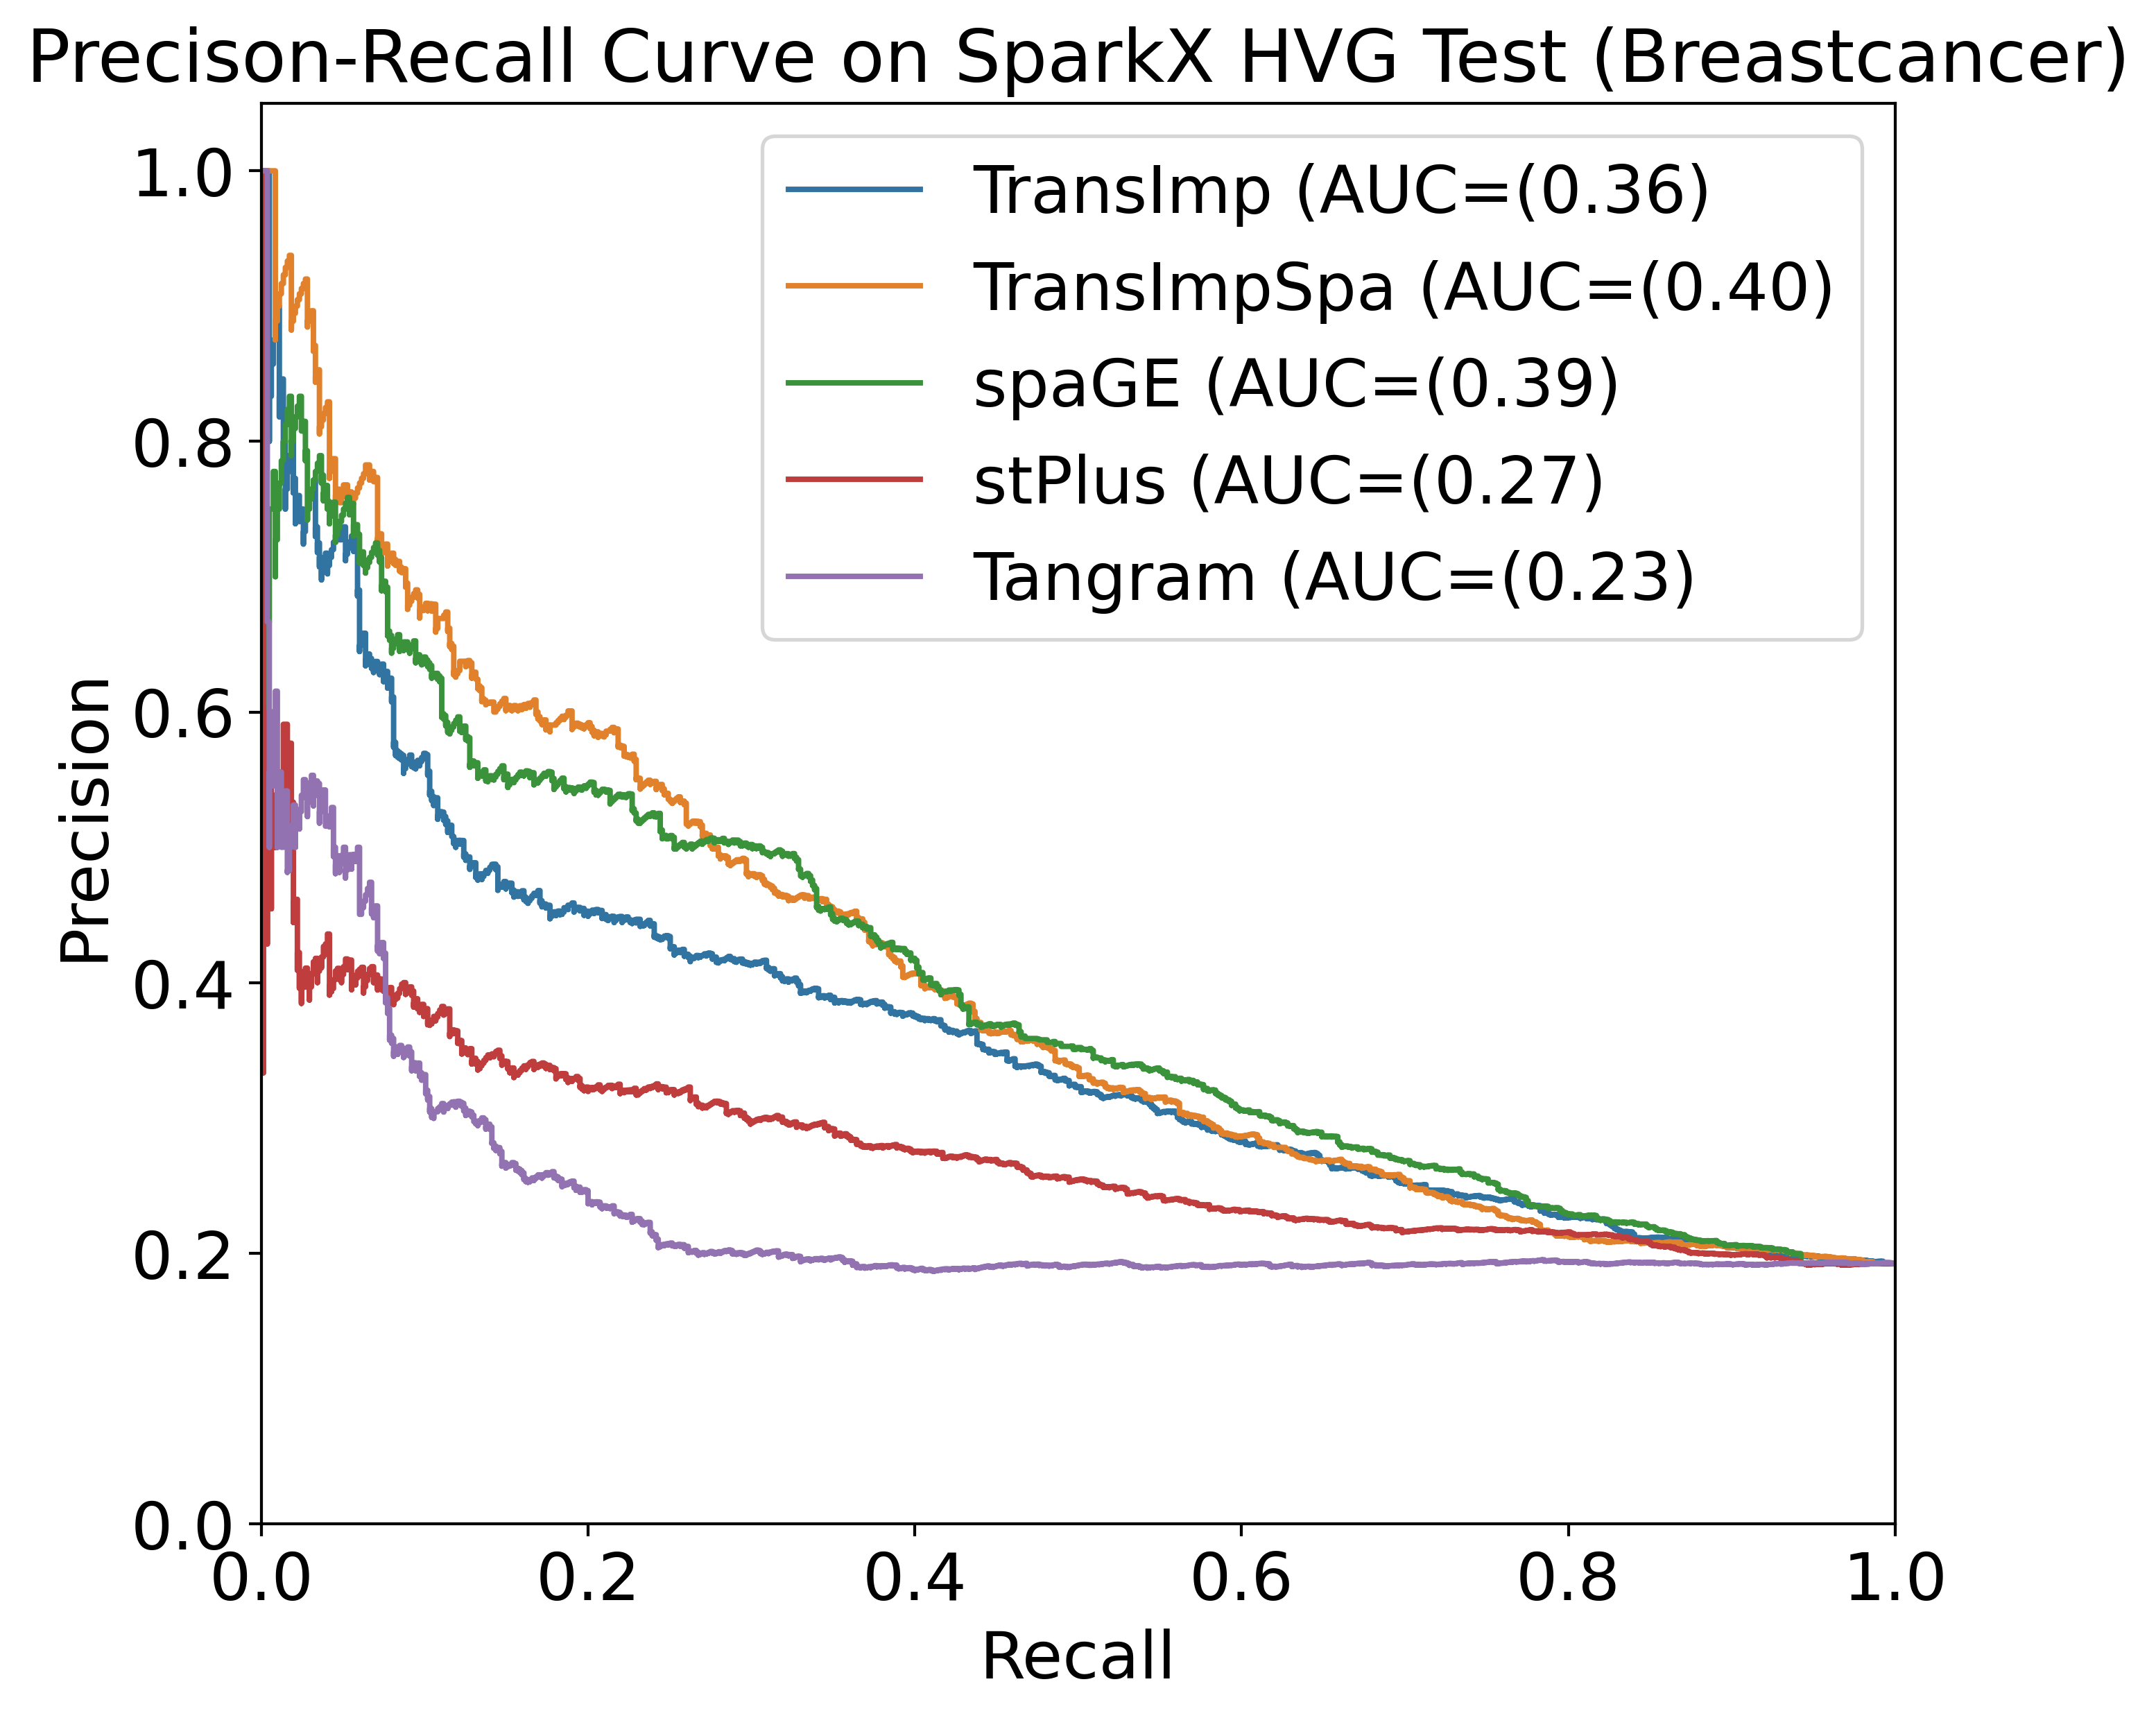

TransImp # 829 pairs, # sig pairs: (Truth): 291, (Preds) 632
TransImpSpa # 829 pairs, # sig pairs: (Truth): 291, (Preds) 608
TransImpCls # 829 pairs, # sig pairs: (Truth): 291, (Preds) 650
TransImpClsSpa # 829 pairs, # sig pairs: (Truth): 291, (Preds) 632
spaGE # 829 pairs, # sig pairs: (Truth): 291, (Preds) 470
stPlus # 813 pairs, # sig pairs: (Truth): 286, (Preds) 427
stPlus Fewer genes than truth: 813 vs 829
Tangram # 829 pairs, # sig pairs: (Truth): 291, (Preds) 701
truth # 829 pairs, # sig pairs: (Truth): 291, (Preds) 291


/tmp/ipykernel_4124788/3741029158.py:139: RuntimeWarning: divide by zero encountered in log
  score =  - np.log(m_adatas[method].uns['global_res'].loc[genes].fdr.values + min(np.min(m_adatas[method].uns['global_res'].loc[genes].fdr.values)/1000, 1e-500))
/tmp/ipykernel_4124788/3741029158.py:139: RuntimeWarning: divide by zero encountered in log
  score =  - np.log(m_adatas[method].uns['global_res'].loc[genes].fdr.values + min(np.min(m_adatas[method].uns['global_res'].loc[genes].fdr.values)/1000, 1e-500))
/tmp/ipykernel_4124788/3741029158.py:139: RuntimeWarning: divide by zero encountered in log
  score =  - np.log(m_adatas[method].uns['global_res'].loc[genes].fdr.values + min(np.min(m_adatas[method].uns['global_res'].loc[genes].fdr.values)/1000, 1e-500))
/tmp/ipykernel_4124788/3741029158.py:139: RuntimeWarning: divide by zero encountered in log
  score =  - np.log(m_adatas[method].uns['global_res'].loc[genes].fdr.values + min(np.min(m_adatas[method].uns['global_res'].loc[genes].fdr.val

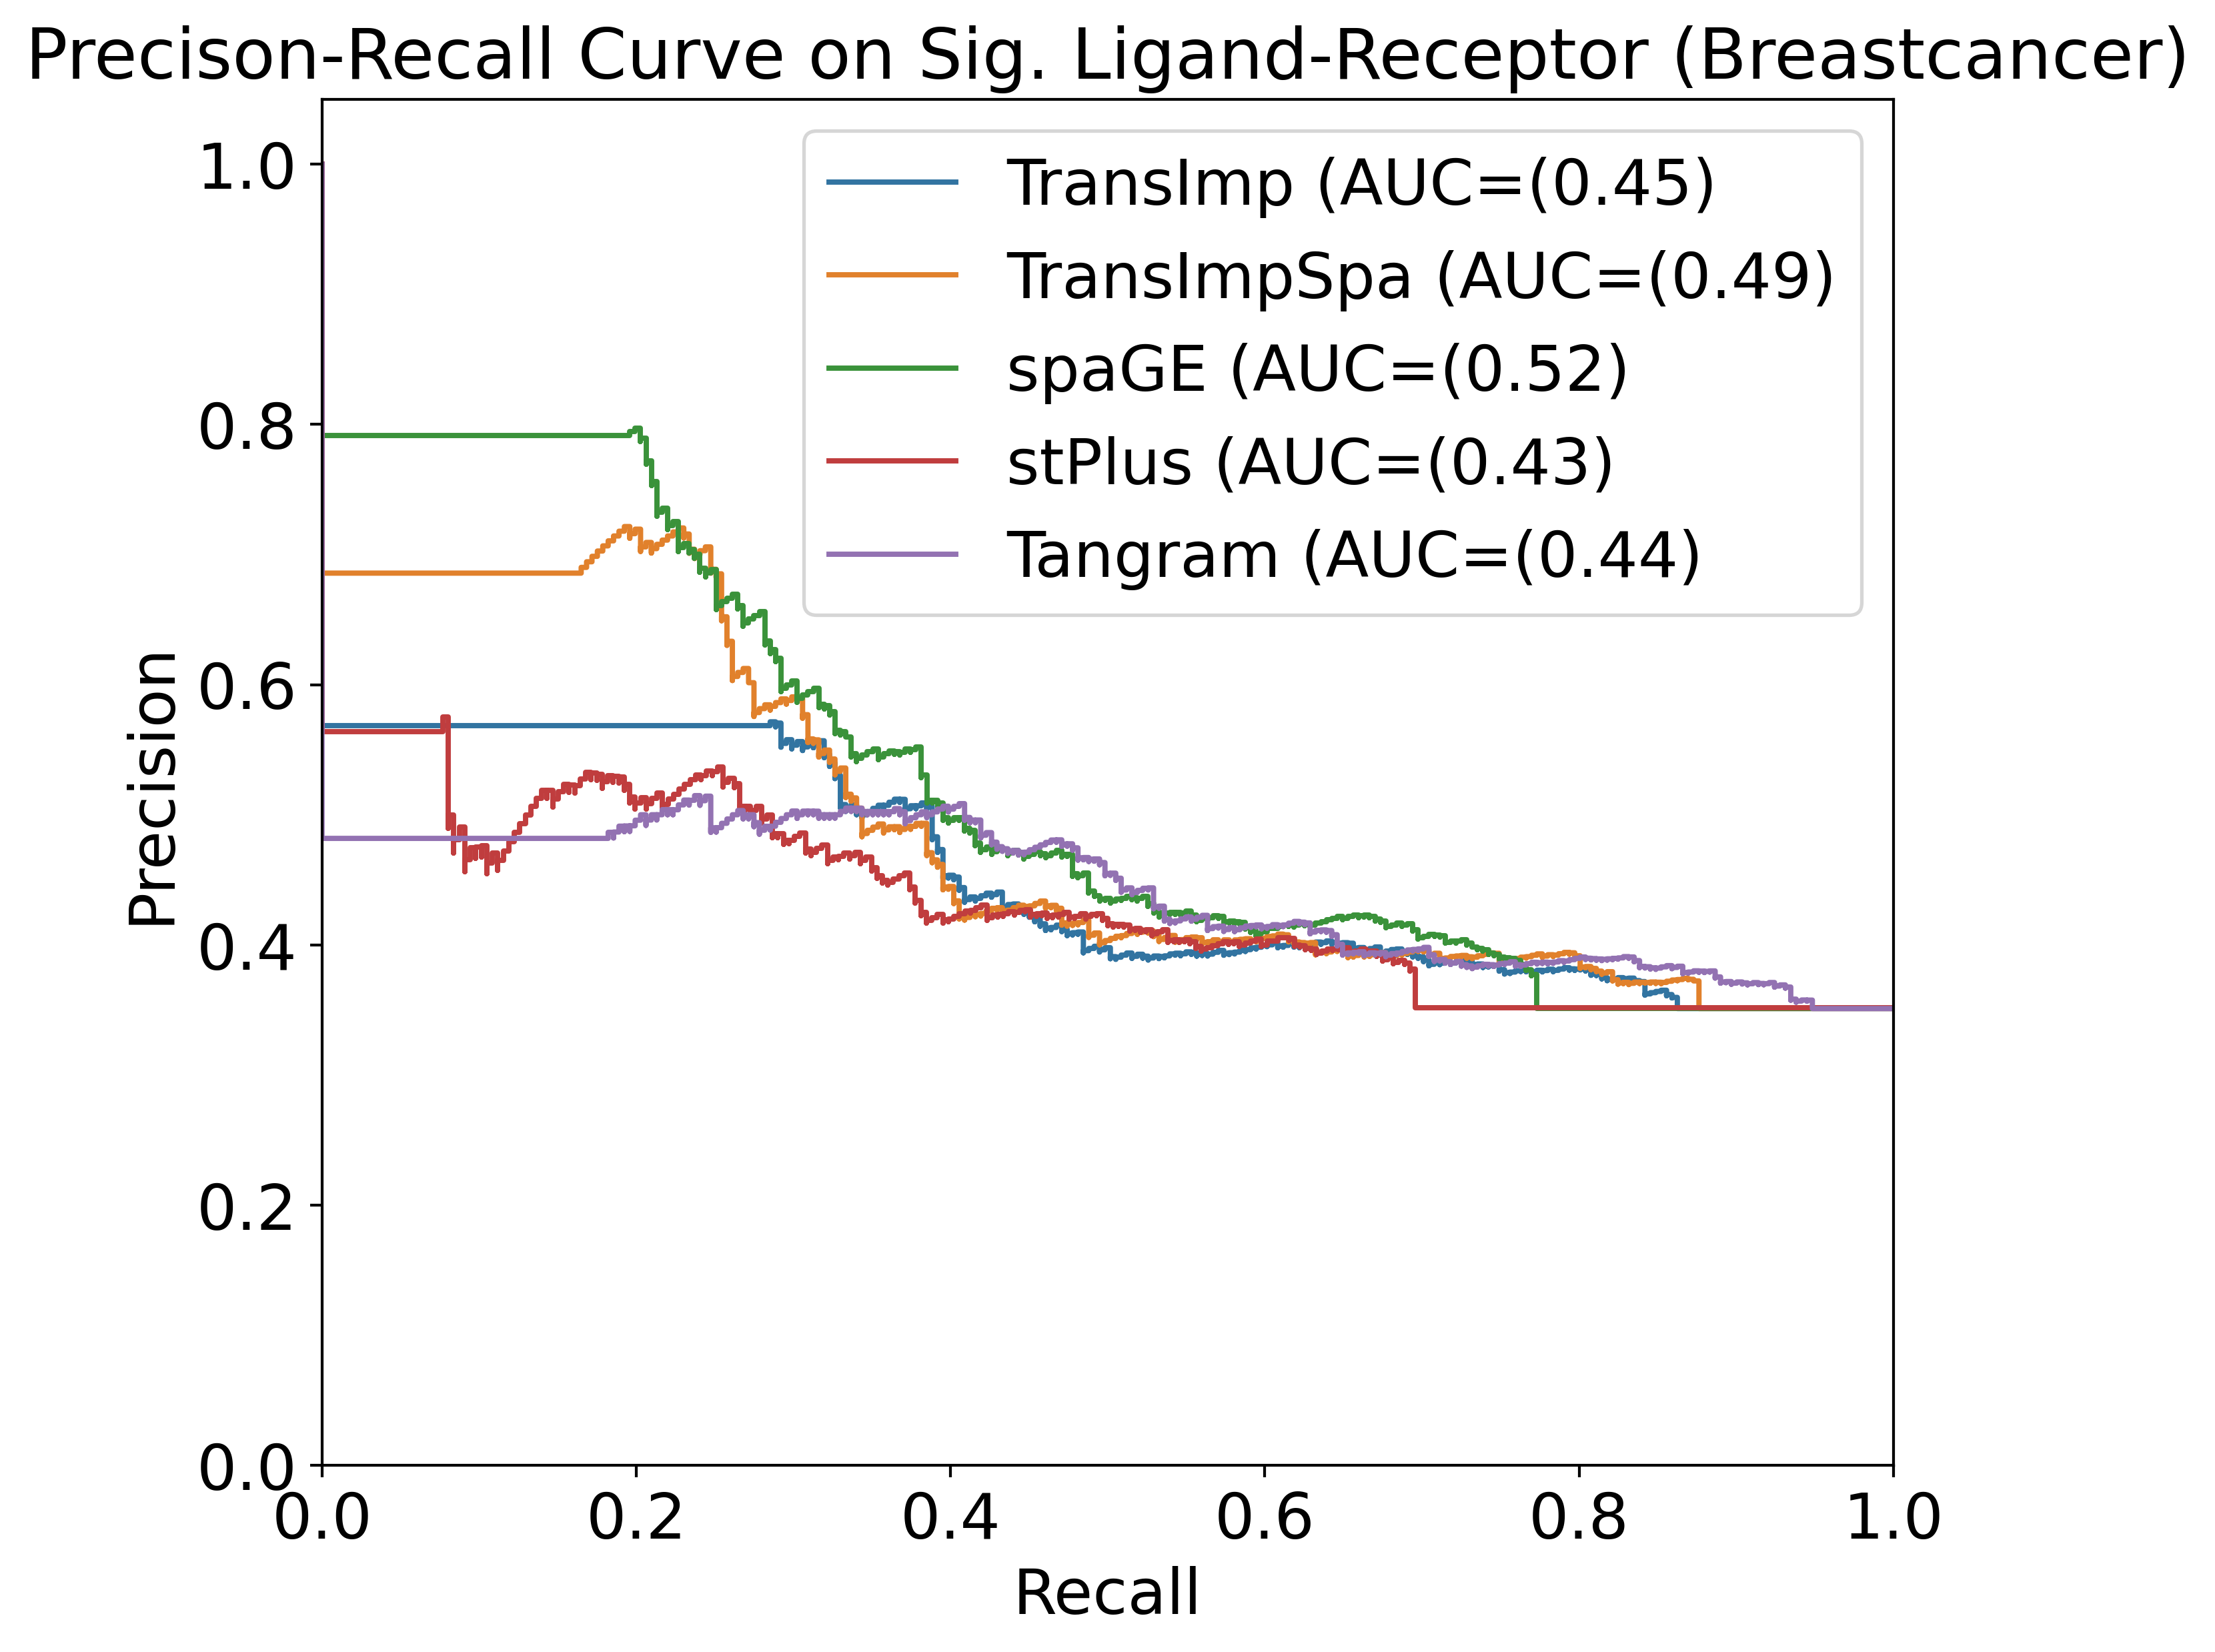

In [4]:
res_cos_gt0_2_ratio = {}
res_mse_moranI_st0_05_ratio = {}
res_meanprec_HVG_moranI = {}
res_meanprec_HVG_sparkx = {}
res_meanprec_LR_spatialdm = {}
res_cos_median = {}
res_mse_I_median = {}

for ST_name in ST_names:
    _cos_rt, _mse_I, _HVG_I, _HVG_sparkx, _LR_spatialDM, _median_mse_I, _median_cos = cmp_scores(ST_name,  0.2, 0.05, 0.01)
    res_cos_gt0_2_ratio.update(_cos_rt)
    res_mse_moranI_st0_05_ratio.update(_mse_I)
    res_meanprec_HVG_moranI.update(_HVG_I)
    res_meanprec_HVG_sparkx.update(_HVG_sparkx)
    res_meanprec_LR_spatialdm.update(_LR_spatialDM)
    res_cos_median.update(_median_cos)
    res_mse_I_median.update(_median_mse_I)

In [5]:
res_cos_gt0_2_ratio

{'mouseliver5fold_cos_gt0.2_ratio': {'TransImp': 0.8233340712862519,
  'TransImpSpa': 0.8226699136595085,
  'TransImpCls': 0.8516714633606376,
  'TransImpClsSpa': 0.8510073057338942,
  'spaGE': 0.7794996679211866,
  'stPlus': 0.7022359973433695,
  'Tangram': 0.849014832853664,
  'truth': 1.0},
 'melanoma5fold_cos_gt0.2_ratio': {'TransImp': 0.7026022304832714,
  'TransImpSpa': 0.6933085501858736,
  'TransImpCls': 0.7128252788104089,
  'TransImpClsSpa': 0.7074349442379182,
  'spaGE': 0.6401486988847583,
  'stPlus': 0.6386617100371748,
  'Tangram': 0.7068773234200744,
  'truth': 1.0},
 'intestine5fold_cos_gt0.2_ratio': {'TransImp': 0.6466725043782837,
  'TransImpSpa': 0.6161704611792177,
  'TransImpCls': 0.6636018680677175,
  'TransImpClsSpa': 0.6468184471687098,
  'spaGE': 0.5926736719206072,
  'stPlus': 0.5583771161704612,
  'Tangram': 0.6609748978400467,
  'truth': 1.0},
 'breastcancer5fold_cos_gt0.2_ratio': {'TransImp': 0.6684744164112237,
  'TransImpSpa': 0.6680028295213393,
  'Trans

In [6]:
m_res = {ST_name:{} for ST_name in ST_names}
for ST_name in ST_names:
    for res in [res_cos_gt0_2_ratio, 
                    res_mse_moranI_st0_05_ratio, 
                    res_meanprec_HVG_moranI, 
                    res_meanprec_HVG_sparkx, 
                    res_meanprec_LR_spatialdm,
                    res_cos_median,
                    res_mse_I_median]:
        for key in res.keys():
            if key.startswith(ST_name):
                m_res[ST_name][key] = res[key]

In [7]:
dict_df_res = {ST_name:pd.DataFrame(m_res[ST_name]) for ST_name in m_res}

In [8]:
def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for contains in ax.containers:
                for p in contains.patches:
                    _x = p.get_x() + p.get_width() / 2
                    _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                    value = '{:.1f}'.format(p.get_height() * 100)
                    ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for contains in ax.containers:
                for p in contains.patches:
                    _x = p.get_x() + p.get_width() + float(space)
                    _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                    value = '{:.1f}'.format(p.get_width() * 100)
                    ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

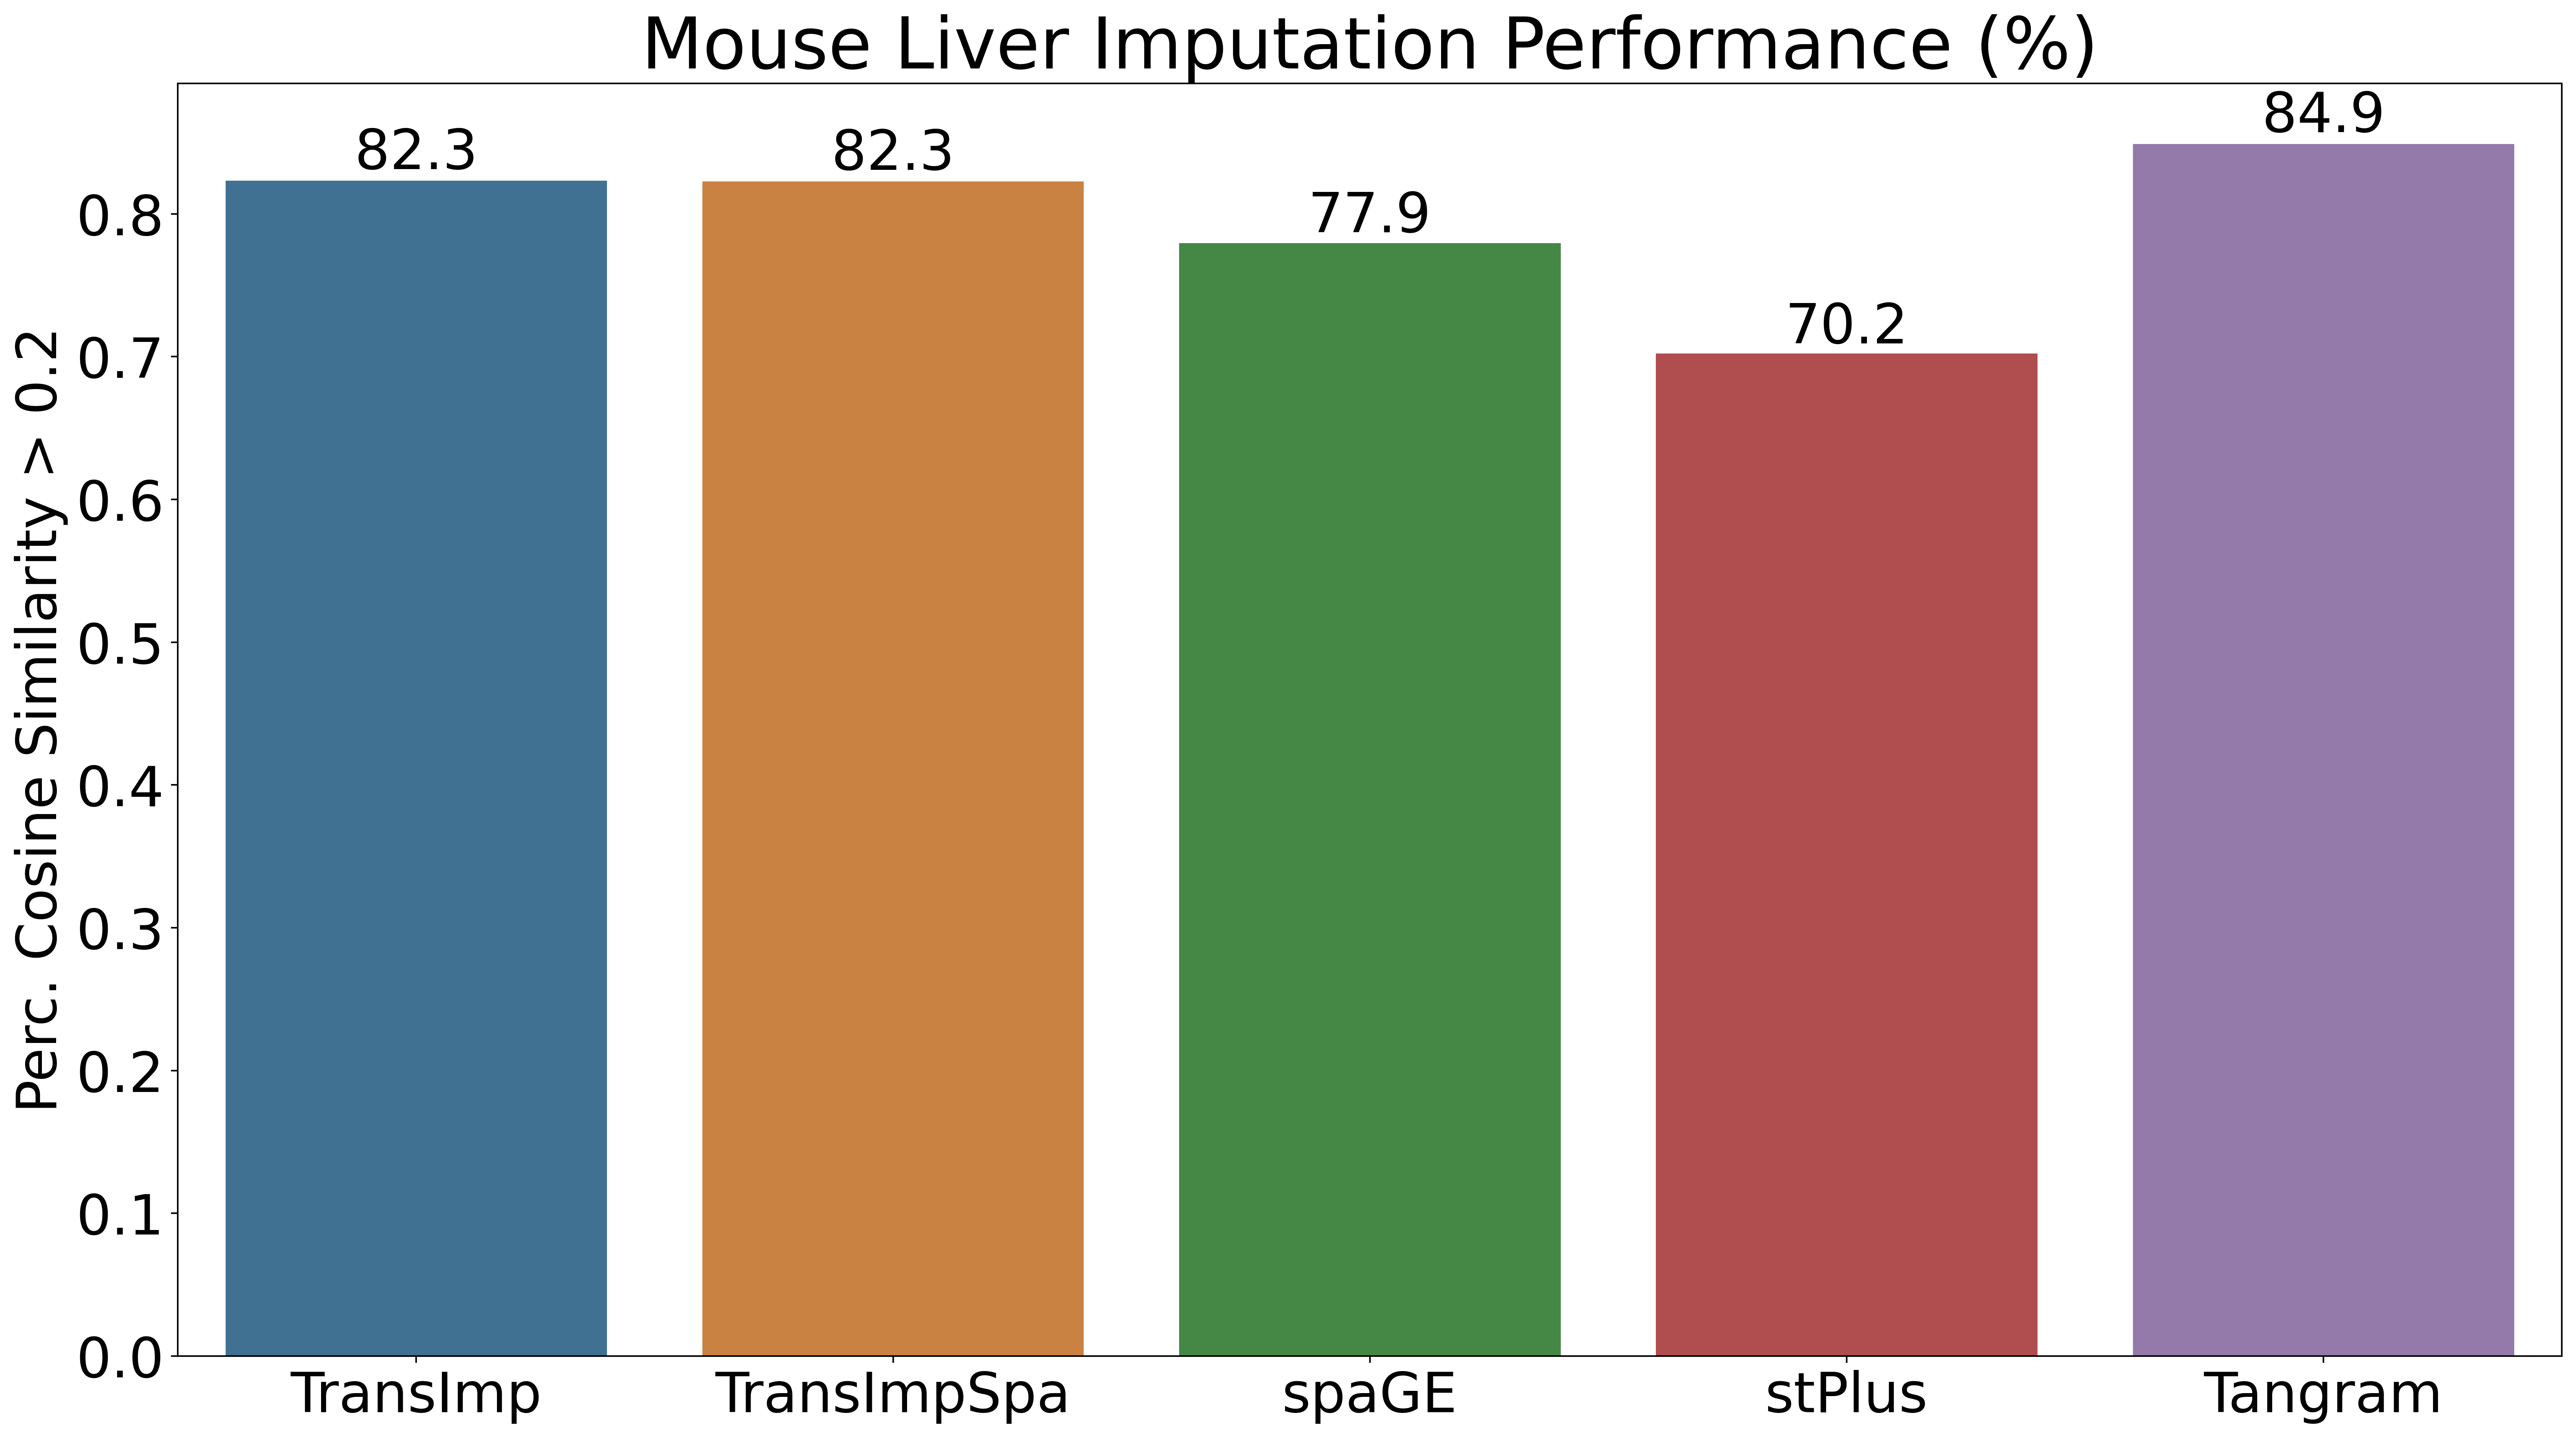

In [9]:
plt.rcParams.update({"font.size":28, 'axes.titlesize':36})
fig, ax = plt.subplots(1, sharey=True, constrained_layout=True)
fig.set_figwidth(18)
fig.set_figheight(10)
fig.set_dpi(380)
sub_df = dict_df_res['mouseliver5fold'].loc[sub_methods]
sns.barplot(ax=ax, x=sub_df.index, palette=color[:5], y=sub_df['mouseliver5fold_cos_gt0.2_ratio']).set(
    ylabel='Perc. Cosine Similarity > 0.2',
    title=f'Mouse Liver Imputation Performance (%)'
    )
show_values(ax)

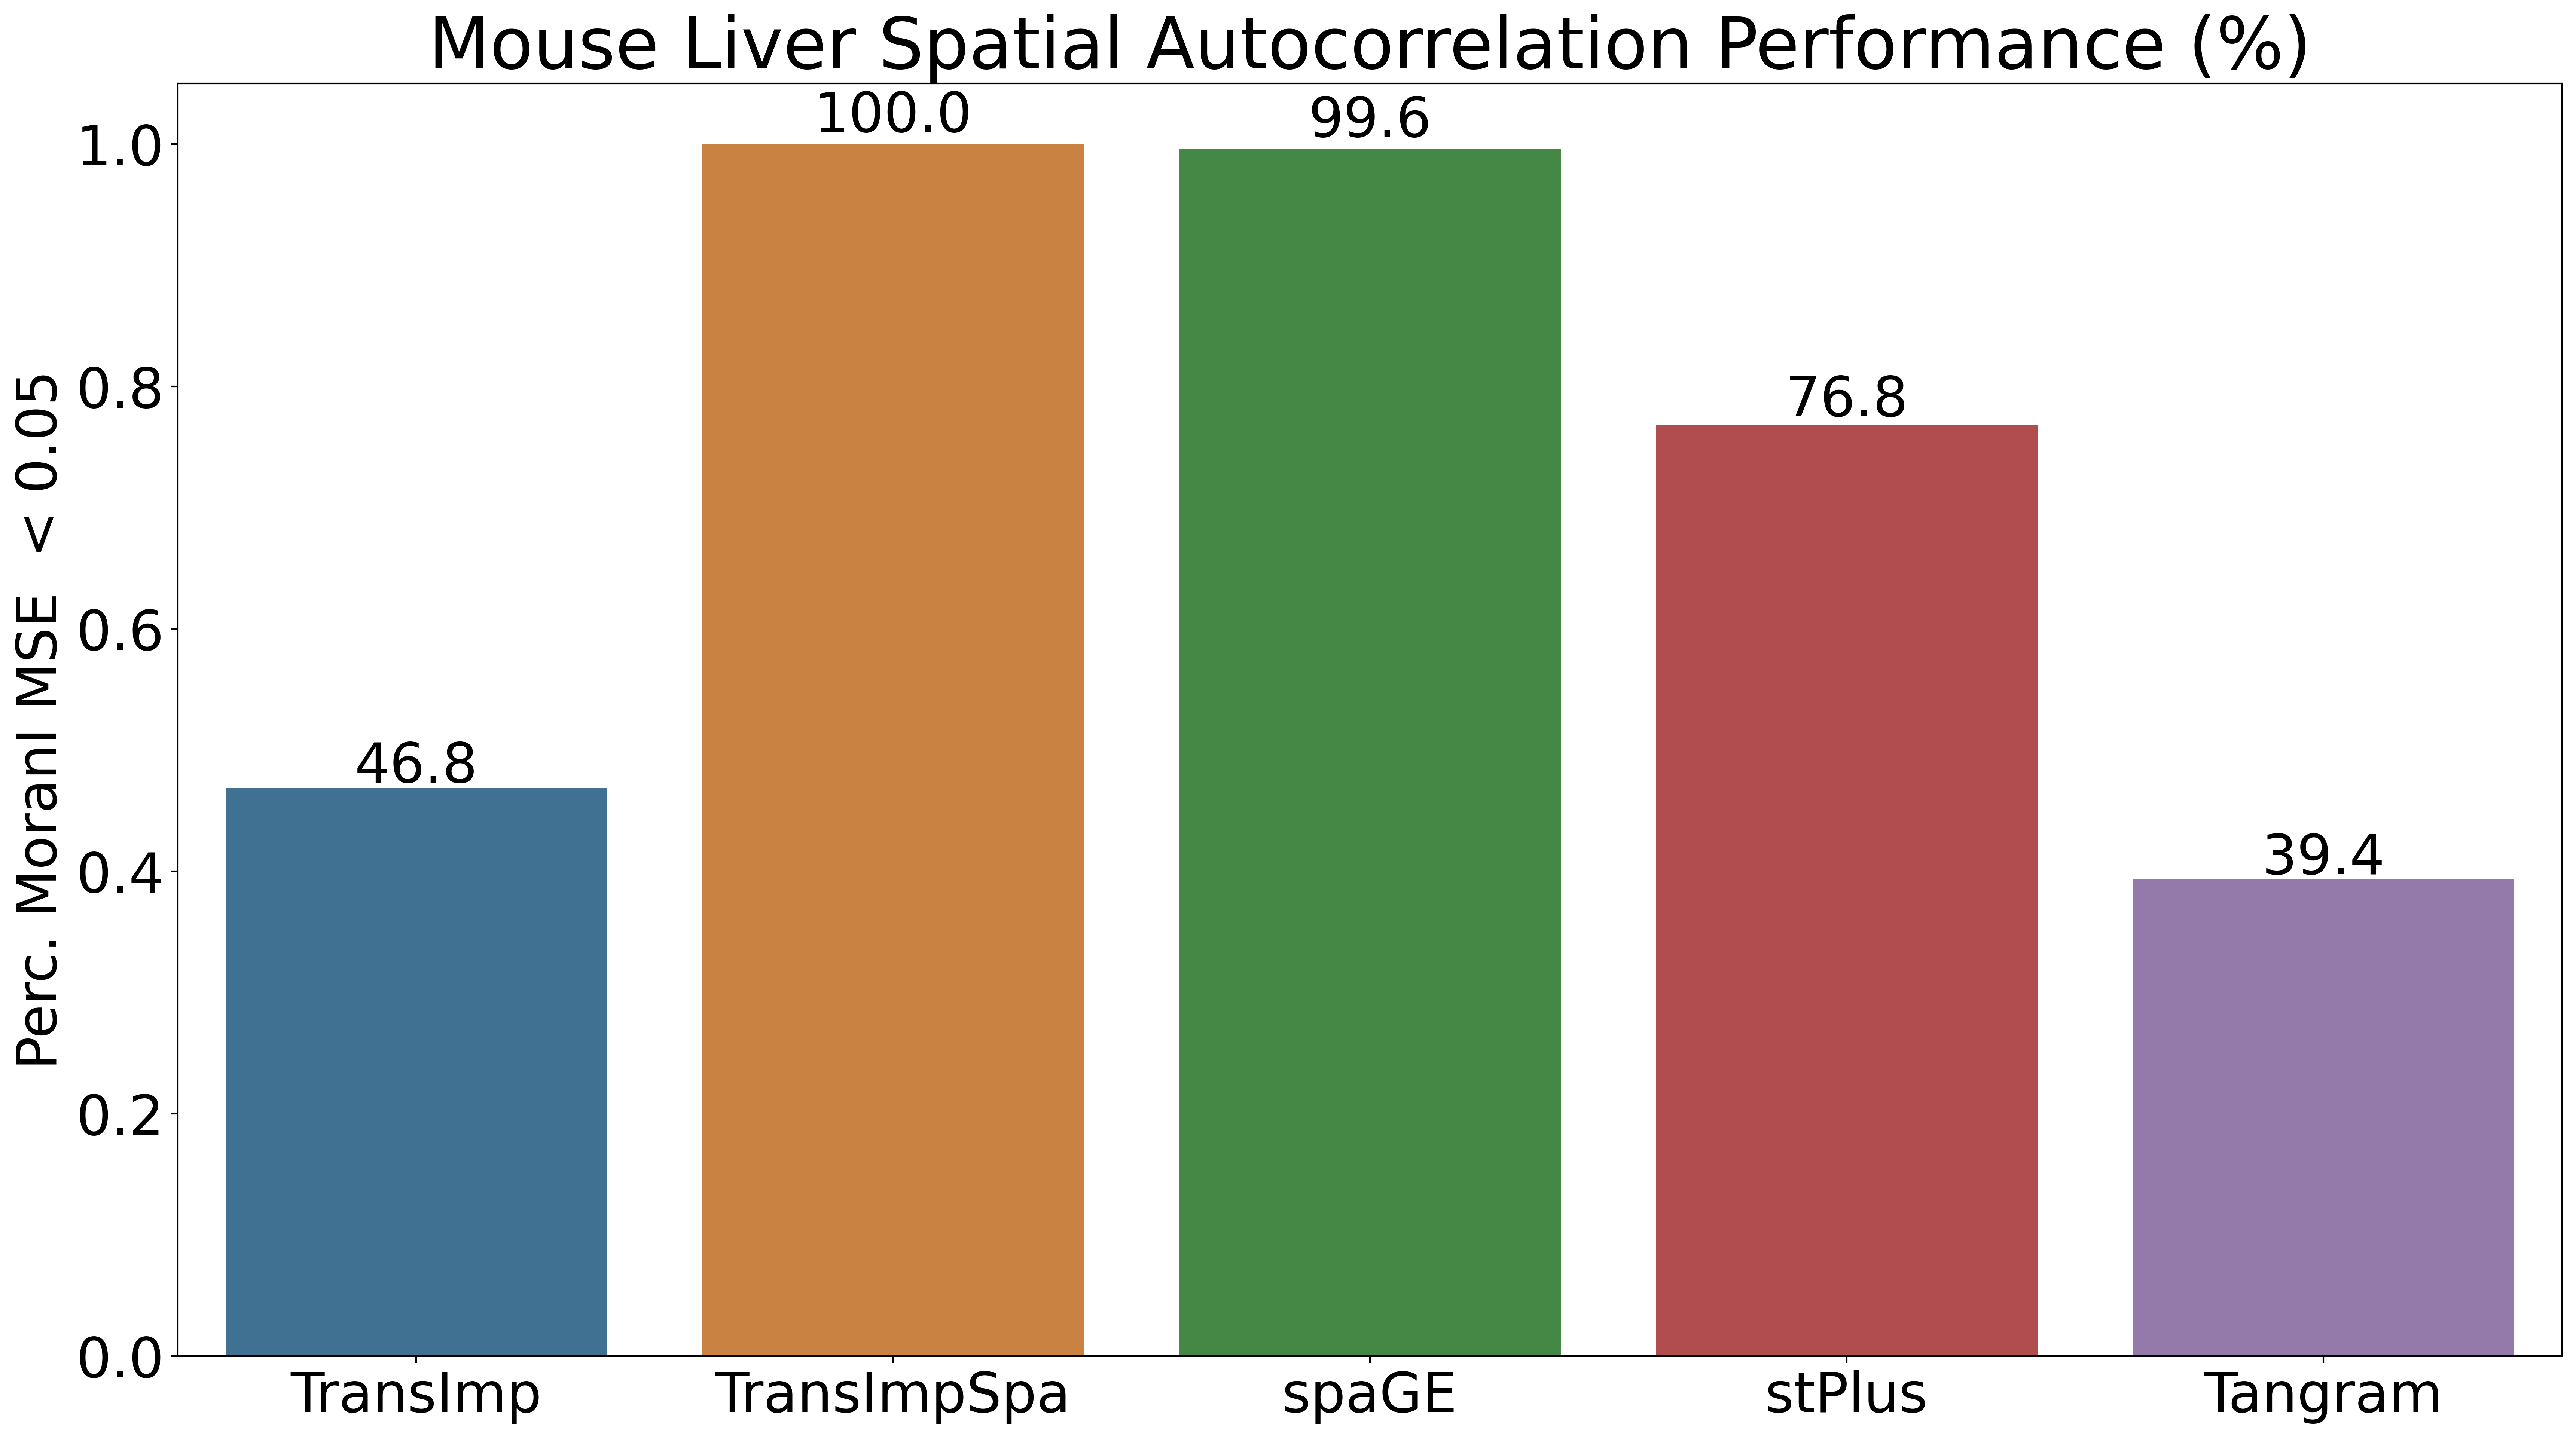

In [10]:
plt.rcParams.update({"font.size":28, 'axes.titlesize':36})
fig, ax = plt.subplots(1, sharey=True, constrained_layout=True)
fig.set_figwidth(18)
fig.set_figheight(10)
fig.set_dpi(380)
sub_df = dict_df_res['mouseliver5fold'].loc[sub_methods]
sns.barplot(ax=ax, x=sub_df.index, palette=color[:5], y=sub_df['mouseliver5fold_mse_moranI_st0.05_ratio']).set(
    ylabel='Perc. MoranI MSE  < 0.05',
    title=f'Mouse Liver Spatial Autocorrelation Performance (%)'
    )
show_values(ax)

In [11]:
dict_df_res[ST_name]

breastcancer5fold_cos_gt0.2_ratio  \
TransImp                                 0.668474   
TransImpSpa                              0.668003   
TransImpCls                              0.682858   
TransImpClsSpa                           0.681679   
spaGE                                    0.587597   
stPlus                                   0.599151   
Tangram                                  0.679557   
truth                                    1.000000   

                breastcancer5fold_mse_moranI_st0.05_ratio  \
TransImp                                         0.402735   
TransImpSpa                                      0.997406   
TransImpCls                                      0.139826   
TransImpClsSpa                                   0.990804   
spaGE                                            1.000000   
stPlus                                           0.748173   
Tangram                                          0.500589   
truth                                            1.000000   

                breastcancer5fold_mean_prec_moranI  \
TransImp                                  0.463257   
TransImpSpa                               0.516761   
TransImpCls                               0.332159   
TransImpClsSpa                            0.454247   
spaGE                                     0.490661   
stPlus                                    0.437220   
Tangram                                   0.325232   
truth                                     1.000000   

                breastcancer5fold_mean_prec_sparkx  \
TransImp                                  0.358976   
TransImpSpa                               0.400092   
TransImpCls                               0.216828   
TransImpClsSpa                            0.232560   
spaGE                                     0.393108   
stPlus                                    0.274017   
Tangram                                   0.232679   
truth                                     1.000000   

                breastcancer5fold_mean_prec_spatialdm  \
TransImp                                     0.453250   
TransImpSpa                                  0.488523   
TransImpCls                                  0.379771   
TransImpClsSpa                               0.385121   
spaGE                                        0.521966   
stPlus                                       0.430345   
Tangram                                      0.440459   
truth                                        1.000000   

                breastcancer5fold_cos_corr  breastcancer5fold_mse_moranI  
TransImp                          0.294394                      0.062654  
TransImpSpa                       0.294444                      0.000277  
TransImpCls                       0.299461                      0.150119  
TransImpClsSpa                    0.298096                      0.000235  
spaGE                             0.249656                      0.002808  
stPlus                            0.256157                      0.026483  
Tangram                           0.296946                      0.049842  
truth                             1.000000                      0.000000

In [12]:
import seaborn as sns
# plt.rcParams.update({"font.size":16, 'axes.titlesize':20})
# fig, axis = plt.subplots(2, 2, sharey=True, constrained_layout=True)
# fig.set_figwidth(25)
# fig.set_figheight(12)
# fig.set_dpi(380)
name_mapping = {"mouseliver5fold":"Mouse Liver", "melanoma5fold": "Melanoma", "intestine5fold": "Intestine", "breastcancer5fold": "Breast Cancer"}
df_all = pd.DataFrame(columns=["method", "dataset", "gmean_score"])
for idx, ST_name in enumerate(dict_df_res):
    # ax = axis[idx//2, idx%2]
    dict_df_res[ST_name]['gmean_score'] = gmean(dict_df_res[ST_name][[f"{ST_name}_cos_gt0.2_ratio", 
                                                                f"{ST_name}_cos_gt0.2_ratio", 
                                                                f"{ST_name}_mean_prec_moranI", 
                                                                f"{ST_name}_mean_prec_sparkx", 
                                                                f"{ST_name}_mean_prec_spatialdm"]], axis=1)
    _df = pd.DataFrame()
    _df['gmean_score'] = dict_df_res[ST_name].loc[sub_methods]['gmean_score'].values
    _df['method'] = dict_df_res[ST_name].loc[sub_methods].index.values
    _df['dataset'] = name_mapping[ST_name]
    df_all = pd.concat([df_all, _df], axis=0)
#     sns.barplot(ax=ax, x=dict_df_res[ST_name].index[:-1], y=dict_df_res[ST_name]['gmean_score'][:-1]).set(
#     ylabel='',
#     title=f'{ST_name.replace("5fold", "").capitalize()}'
#     )     
#     ax.bar_label(ax.containers[0])   

# fig.text(-0.015, 0.5, "Geometric Mean Score", va='center', rotation='vertical', fontsize=16)                                             

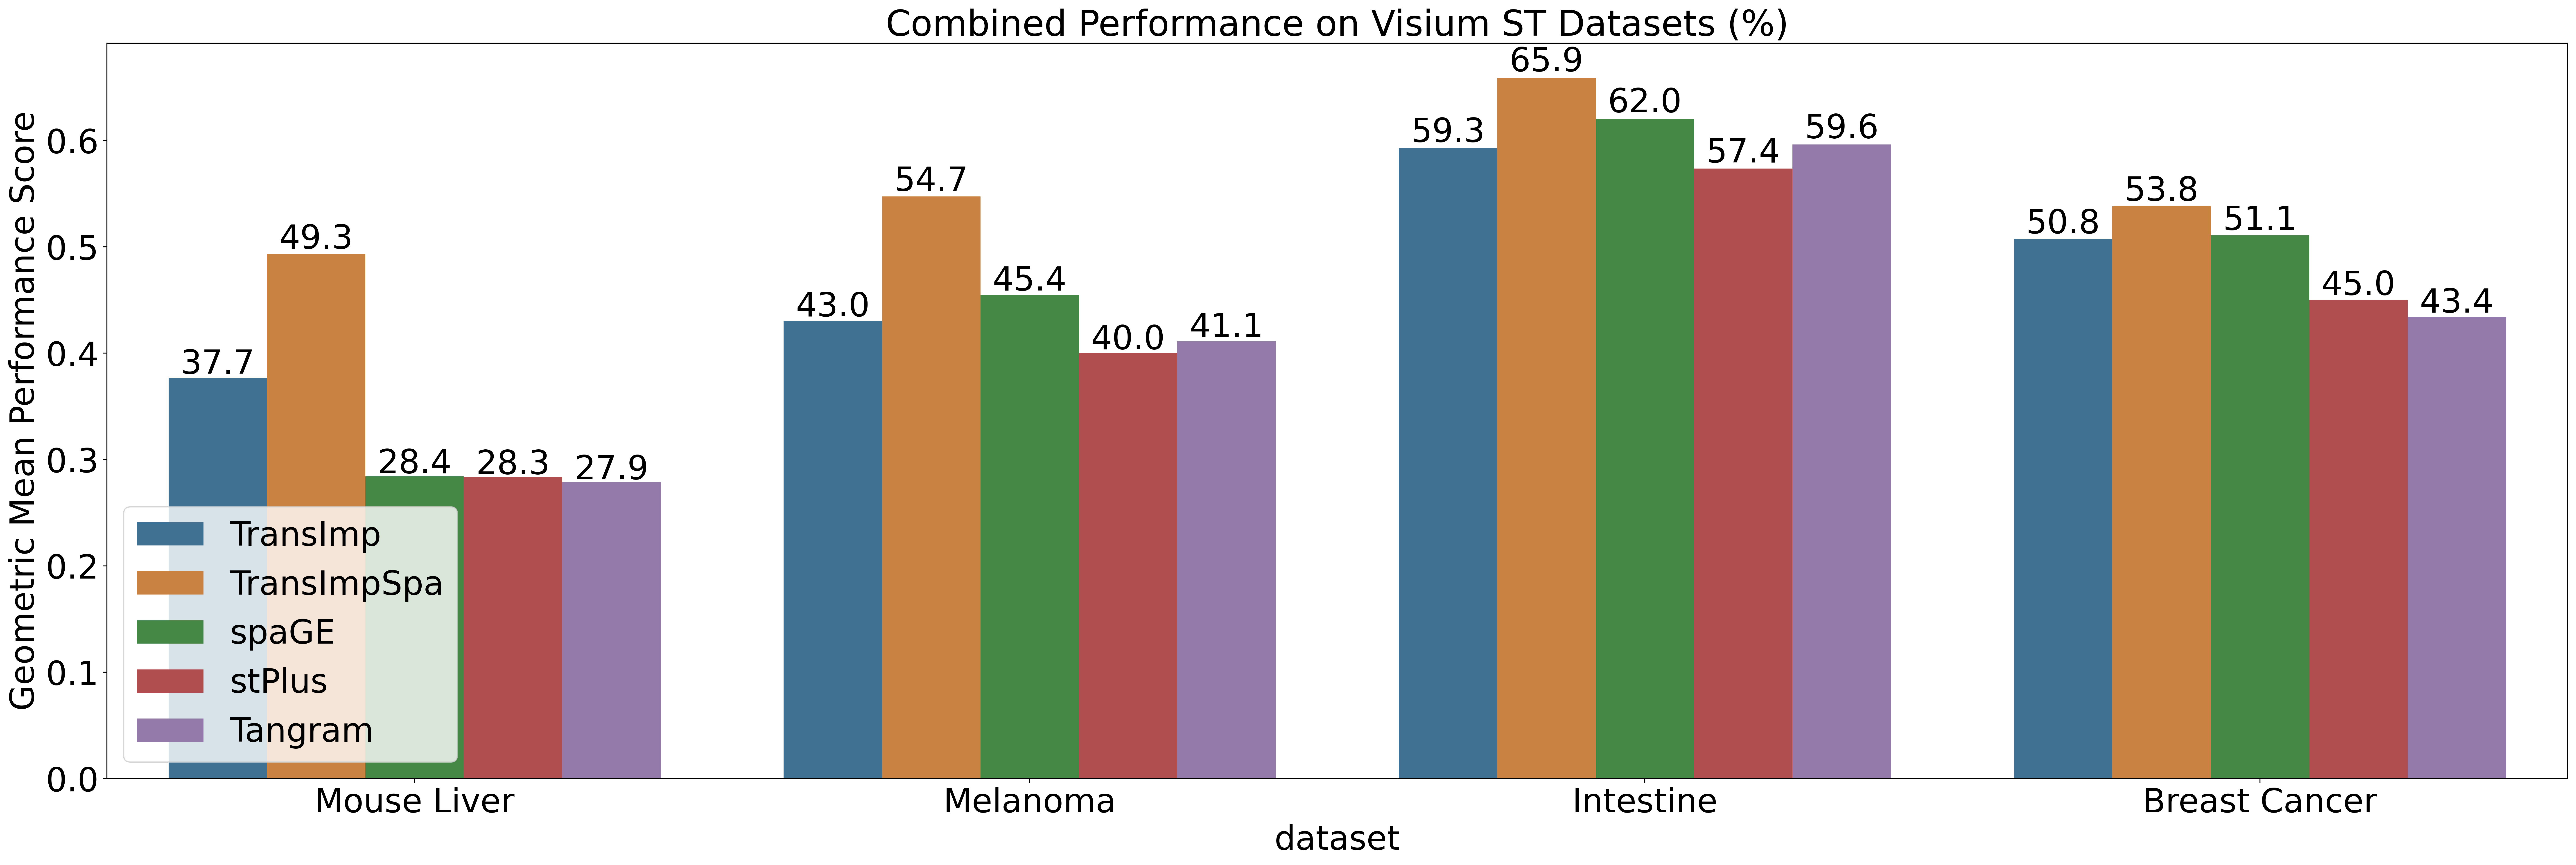

In [13]:
 
plt.rcParams.update({"font.size":28, 'axes.titlesize':30})
fig, ax = plt.subplots(1, sharey=True, constrained_layout=True)
fig.set_figwidth(30)
fig.set_figheight(10)
fig.set_dpi(380)
sns.barplot(ax=ax, data=df_all, x='dataset', y='gmean_score', hue="method", order=name_mapping.values(), hue_order=sub_methods, palette=color[:5]).set(
    ylabel='Geometric Mean Performance Score',
    title="Combined Performance on Visium ST Datasets (%)"
)     
ax.legend(loc="lower left")
show_values(ax)

In [14]:
for method in dict_df_res:
    print(method)
    print(dict_df_res[method].to_latex())

mouseliver5fold
\begin{tabular}{lrrrrrrrr}
\toprule
{} &  mouseliver5fold\_cos\_gt0.2\_ratio &  mouseliver5fold\_mse\_moranI\_st0.05\_ratio &  mouseliver5fold\_mean\_prec\_moranI &  mouseliver5fold\_mean\_prec\_sparkx &  mouseliver5fold\_mean\_prec\_spatialdm &  mouseliver5fold\_cos\_corr &  mouseliver5fold\_mse\_moranI &  gmean\_score \\
\midrule
TransImp       &                         0.823334 &                                 0.468453 &                          0.282989 &                          0.121755 &                             0.325609 &                  0.505653 &                    0.053356 &     0.376896 \\
TransImpSpa    &                         0.822670 &                                 1.000000 &                          0.498326 &                          0.237356 &                             0.364943 &                  0.502853 &                    0.000350 &     0.493308 \\
TransImpCls    &                         0.851671 &                                 0.2273

/tmp/ipykernel_4124788/3586154355.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(dict_df_res[method].to_latex())
